<a href="https://www.kaggle.com/code/theinkyawlwin/time-series-analysis-for-wikipedia-web-traffic?scriptVersionId=247421221" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Load preprocessed csv data

Seperate Kaggle Notebook for data preprocessing can be found [here](https://www.kaggle.com/code/theinkyawlwin/data-preprocessing-for-wikipedia-web-traffic)

In [1]:
# Load preprocessed csv data

library(data.table)

top_page_df <- fread("/kaggle/input/wikipedia/top_page_df.csv")
top_page_df[, Date := as.Date(Date)]
head(top_page_df)

Date,Views
<date>,<dbl>
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77
2015-07-06,22.54


## Plot the page with maximum views

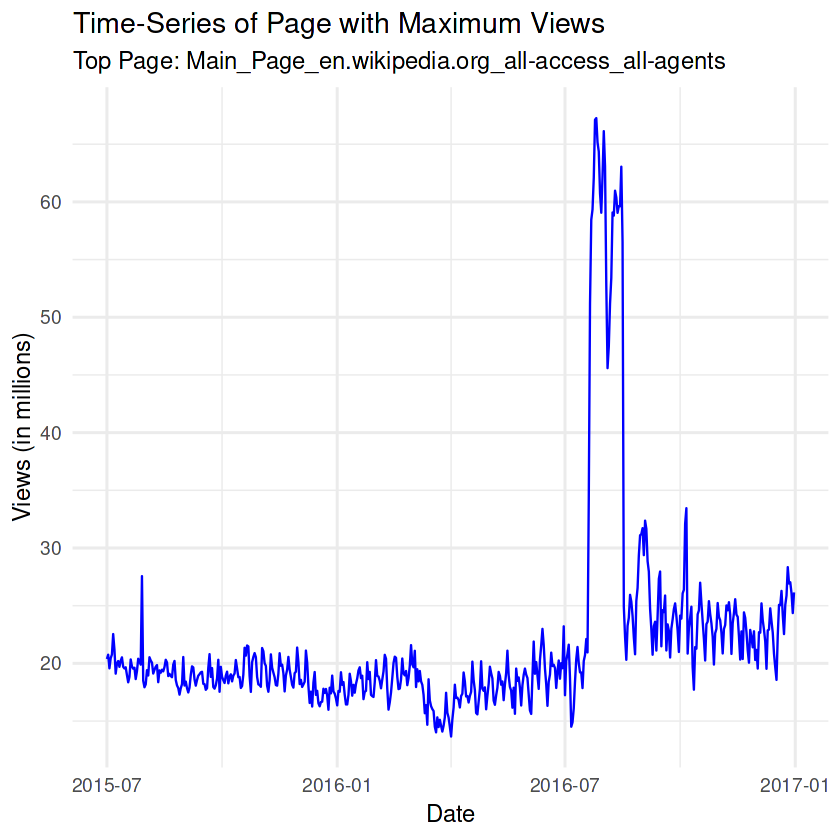

In [2]:
# Plot the time-series data for the page with maximum views
library(ggplot2)

ggplot(top_page_df, aes(x = Date, y = Views)) +
  geom_line(color = "blue", linewidth = 0.5) +
  labs(
    title = "Time-Series of Page with Maximum Views",
    subtitle = paste("Top Page: Main_Page_en.wikipedia.org_all-access_all-agents"),
    x = "Date", 
    y = "Views (in millions)"
  ) +
  theme_minimal(base_size = 14)

# Anomaly detection using Isolation Forest

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


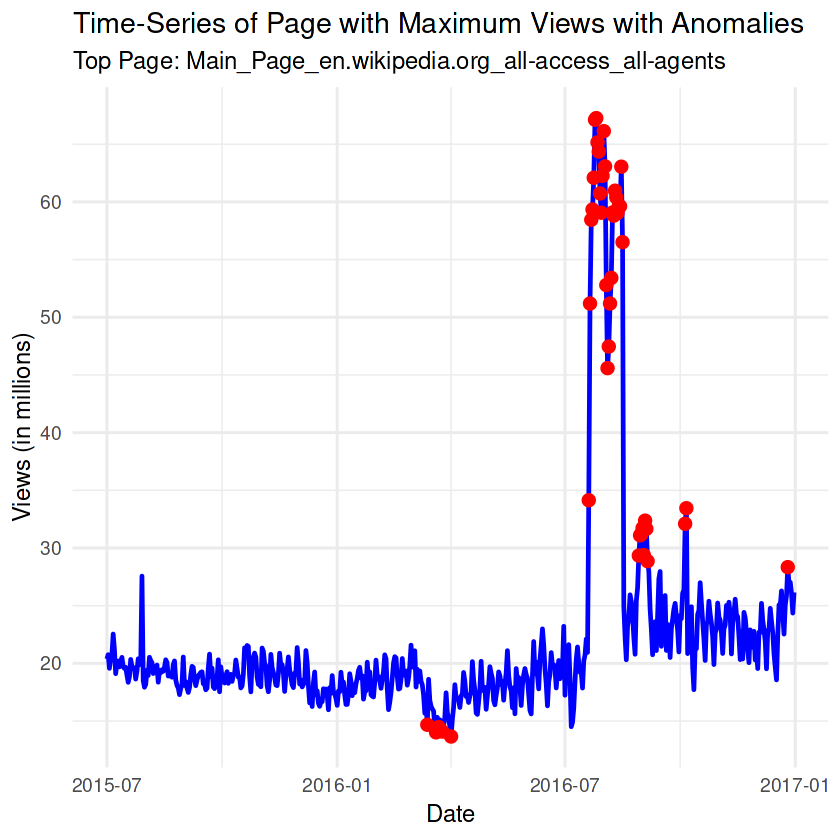

In [3]:
library(data.table)
library(ggplot2)
library(isotree)


# Fit the Isolation Forest model without contamination rate
isolation_forest_model <- isolation.forest(top_page_df[, .(Views)], sample_size = 256, ntrees = 100, seed = 1)

# Predict anomalies using the Isolation Forest model
anomaly_scores <- predict(isolation_forest_model, top_page_df[, .(Views)], type = "score")

# Calculate the threshold for contamination rate of 0.08
threshold <- quantile(anomaly_scores, 0.92)  # since 1 - 0.08 = 0.92

# Mark anomalies
top_page_df[, anomaly := ifelse(anomaly_scores >= threshold, -1, 1)]

# Create a data frame for anomalies
anomaly_df <- top_page_df[anomaly == -1]

# Plot the time-series data with anomalies highlighted
ggplot() +
  geom_line(data = top_page_df, aes(x = Date, y = Views), color = "blue", size = 1) +
  geom_point(data = anomaly_df, aes(x = Date, y = Views), color = "red", size = 3) +
  labs(
    title = "Time-Series of Page with Maximum Views with Anomalies",
    subtitle = paste("Top Page: Main_Page_en.wikipedia.org_all-access_all-agents"),
    x = "Date", 
    y = "Views (in millions)"
  ) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top")


## Removing anomalies from the data

In [4]:
# Create a new column 'new_views' where anomalies are replaced with NA
top_page_df[, new_views := ifelse(anomaly == -1, NA, Views)]


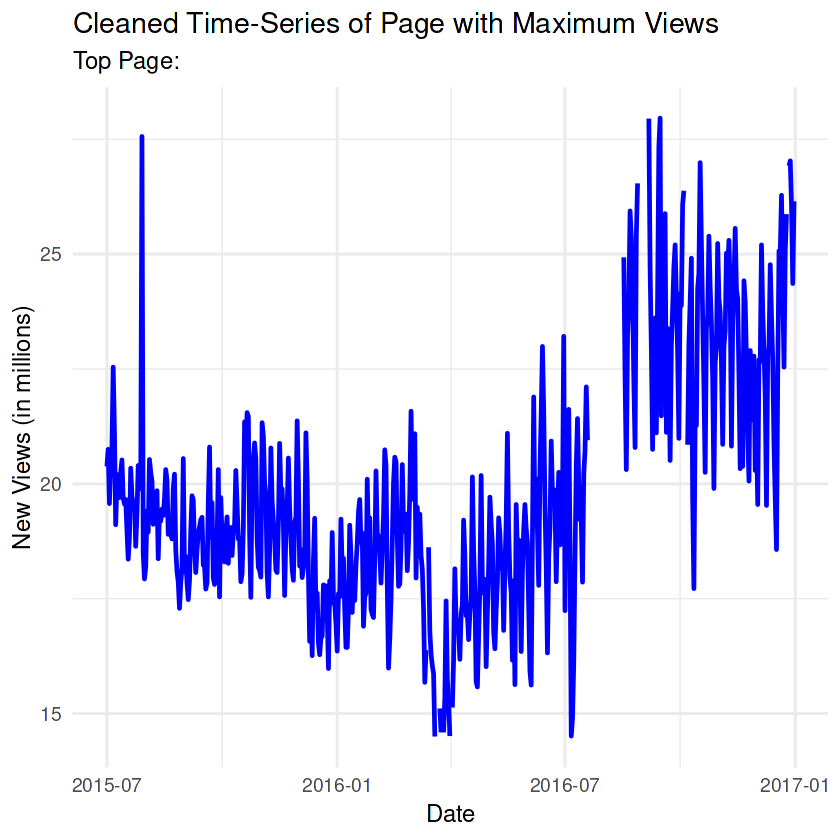

In [5]:
ggplot(top_page_df, aes(x = Date, y = new_views)) +
  geom_line(color = "blue", size = 1) +
  labs(
    title = "Cleaned Time-Series of Page with Maximum Views",
    subtitle = paste("Top Page: "),
    x = "Date", 
    y = "New Views (in millions)"
  ) +
  theme_minimal(base_size = 14)


## Filling missing data with rolling mean

In [6]:
# Install the zoo package if not already installed
# install.packages("zoo")

library(zoo)

# Calculate the rolling mean
top_page_df[, rolling_mean := rollapply(new_views, width = 30, FUN = mean, fill = NA, align = "right", na.rm = TRUE)]



Attaching package: ‘zoo’




The following objects are masked from ‘package:data.table’:

    yearmon, yearqtr




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [7]:
# Fill only NA values with the rolling mean
top_page_df[, new_views := ifelse(is.na(new_views), rolling_mean, new_views)]


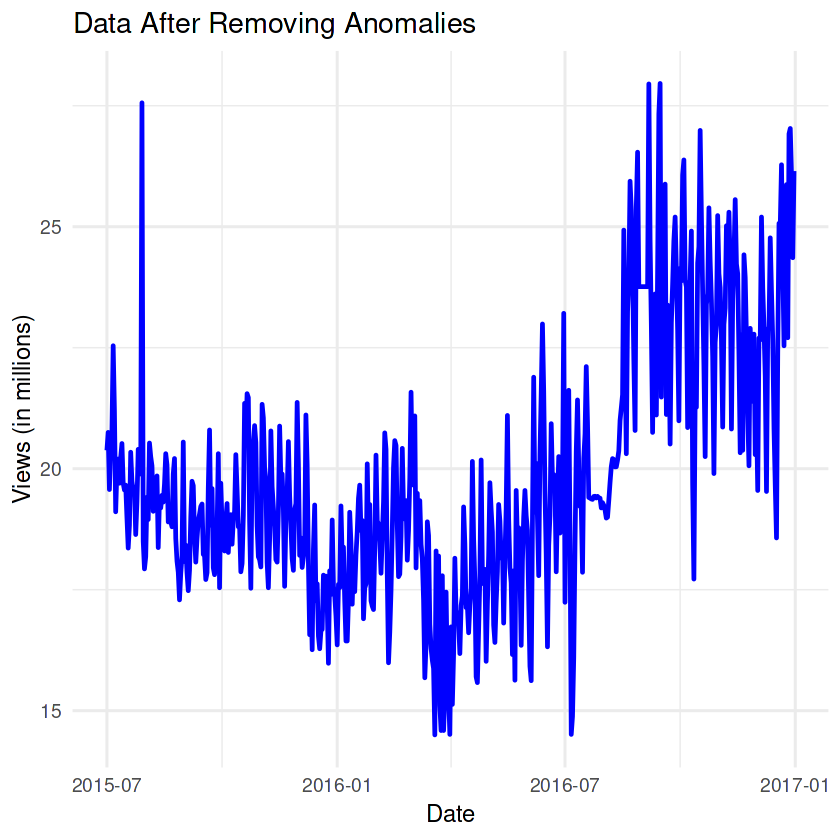

In [8]:
# Plot the cleaned data with anomalies filled using rolling mean
ggplot(top_page_df, aes(x = Date, y = new_views)) +
  geom_line(color = "blue", size = 1) +
  labs(
    title = "Data After Removing Anomalies",
    x = "Date", 
    y = "Views (in millions)"
  ) +
  theme_minimal(base_size = 14)


## Drop unnecessary columns

In [9]:
# Print the column names of the data frame
print(names(top_page_df))


[1] "Date"         "Views"        "anomaly"      "new_views"    "rolling_mean"


In [10]:
top_page_df <- top_page_df[, !c("Views", "anomaly", "rolling_mean"), with = FALSE] # Check the resulting data frame 
print(head(top_page_df))

         Date new_views
       <Date>     <num>
1: 2015-07-01     20.38
2: 2015-07-02     20.75
3: 2015-07-03     19.57
4: 2015-07-04     20.44
5: 2015-07-05     20.77
6: 2015-07-06     22.54


In [11]:
# Rename 'new_views' to 'Views' 
setnames(top_page_df, "new_views", "Views")
print(head(top_page_df))

         Date Views
       <Date> <num>
1: 2015-07-01 20.38
2: 2015-07-02 20.75
3: 2015-07-03 19.57
4: 2015-07-04 20.44
5: 2015-07-05 20.77
6: 2015-07-06 22.54


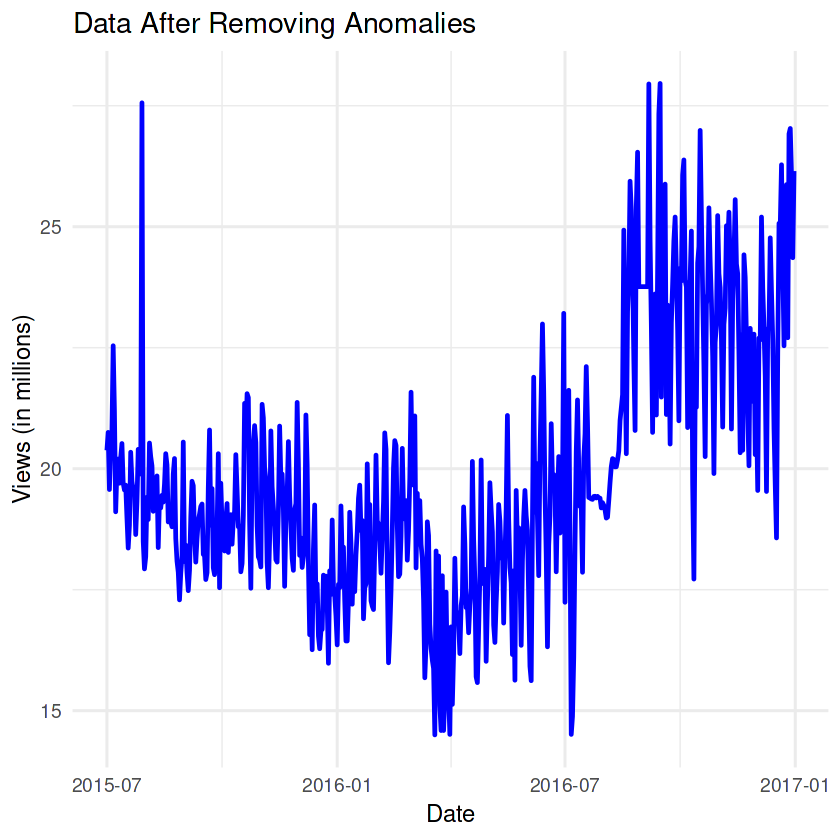

In [12]:
# Plot the cleaned data with anomalies filled using rolling mean
ggplot(top_page_df, aes(x = Date, y = Views)) +
  geom_line(color = "blue", size = 1) +
  labs(
    title = "Data After Removing Anomalies",
    x = "Date", 
    y = "Views (in millions)"
  ) +
  theme_minimal(base_size = 14)


In [13]:
# Saving csv files after treating anomalies

fwrite(top_page_df, "/kaggle/working/top_page_cleaned_df.csv")

# EDA

## ACF

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



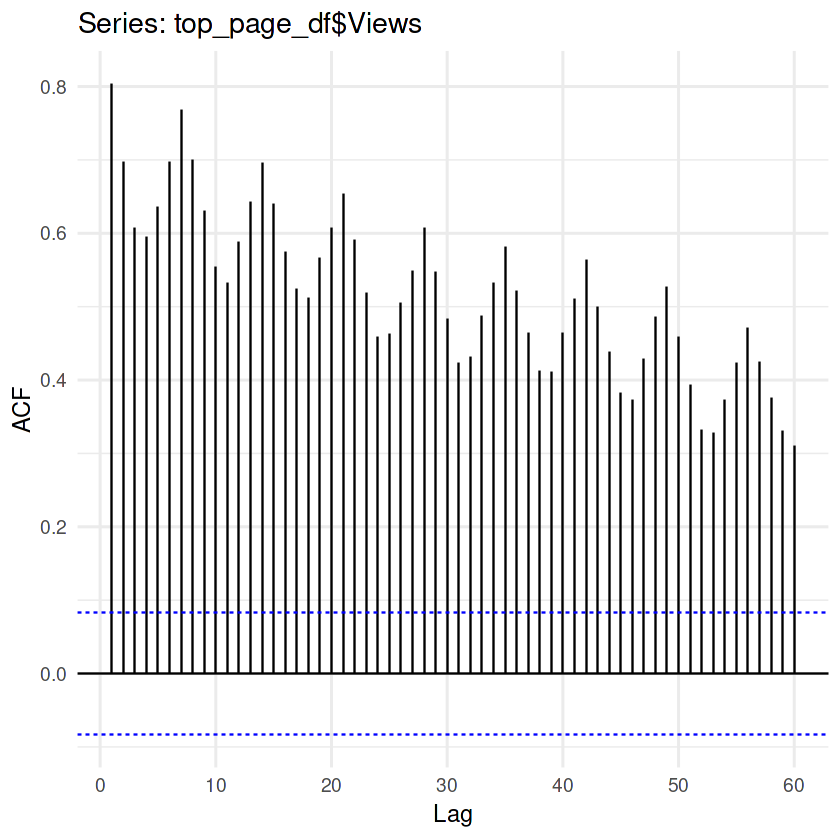

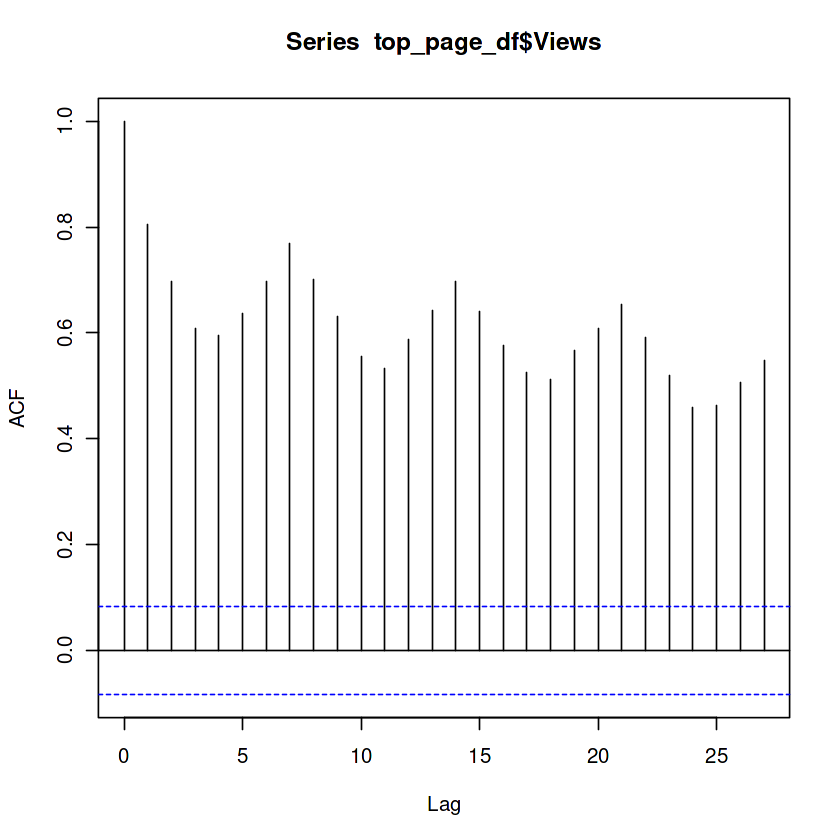

In [14]:
# Install the forecast package if not already installed
# install.packages("forecast")

library(ggplot2)
library(forecast)

# Plot the ACF
acf_plot <- ggAcf(top_page_df$Views, lag.max = 60)+
  theme_minimal(base_size = 14)

# Show the plot
print(acf_plot)

acf(top_page_df$Views)


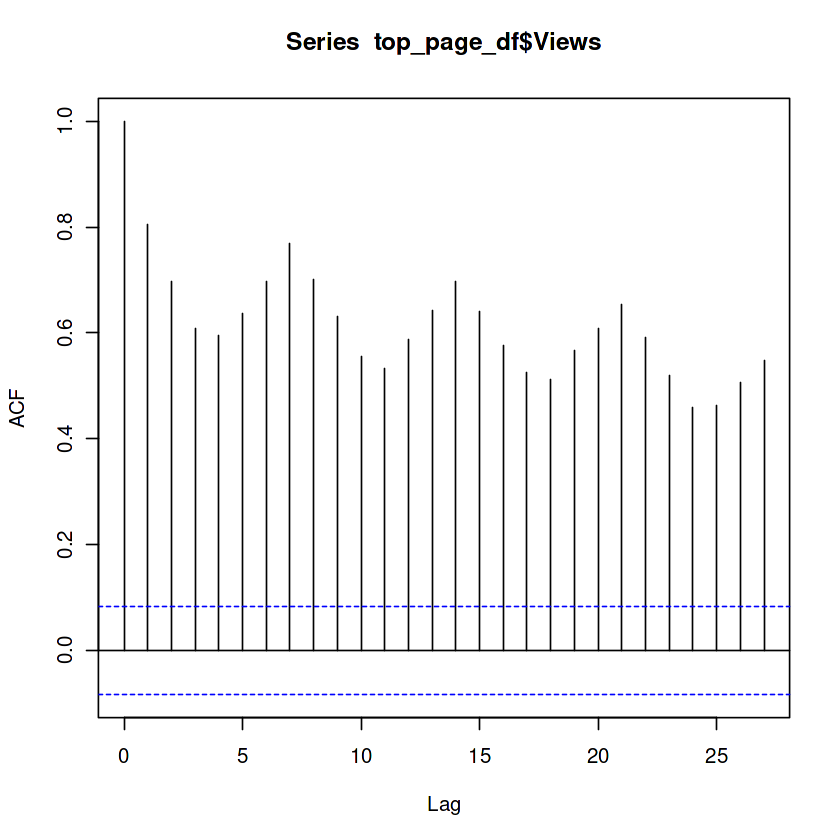

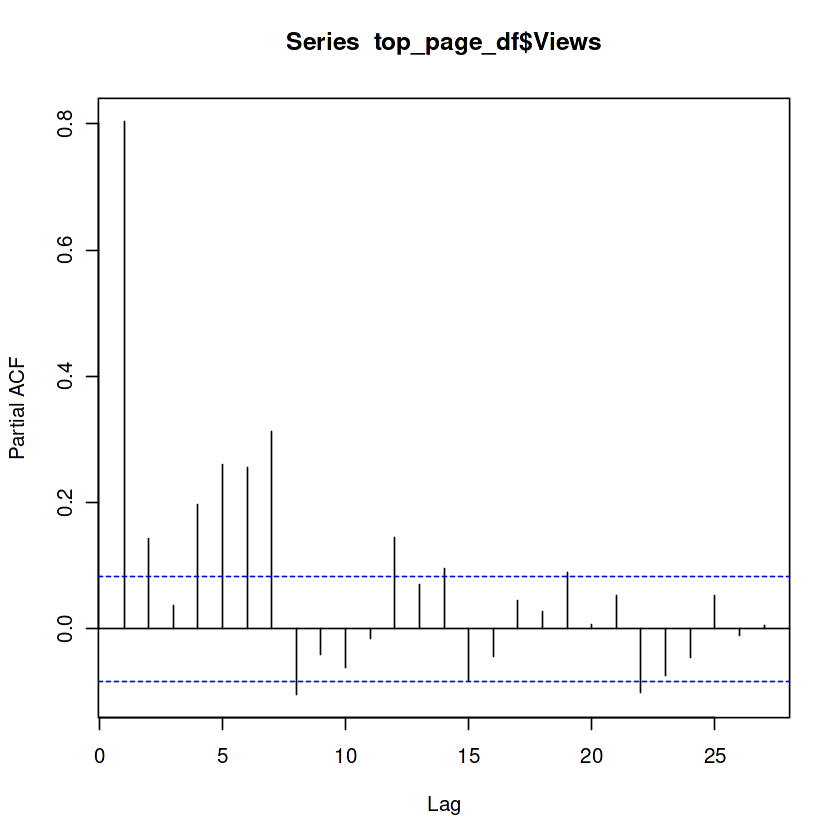

In [15]:
acf(top_page_df$Views)
pacf(top_page_df$Views)

In [16]:
# Install the xts package if not already installed
# install.packages("xts")

library(data.table)
library(ggplot2)
library(isotree)
library(zoo)
library(forecast)
library(xts)



Attaching package: ‘xts’




The following objects are masked from ‘package:data.table’:

    first, last




In [17]:
ts_views <- ts(top_page_df$Views, frequency = 30)


In [18]:
ts_decomposition <- stl(ts_views, s.window = "periodic")


In [19]:
decomposed_df <- data.table(
  Date = top_page_df$Date,
  Observed = ts_decomposition$time.series[, "seasonal"] + ts_decomposition$time.series[, "trend"],
  Seasonal = ts_decomposition$time.series[, "seasonal"],
  Trend = ts_decomposition$time.series[, "trend"],
  Remainder = ts_decomposition$time.series[, "remainder"]
)


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


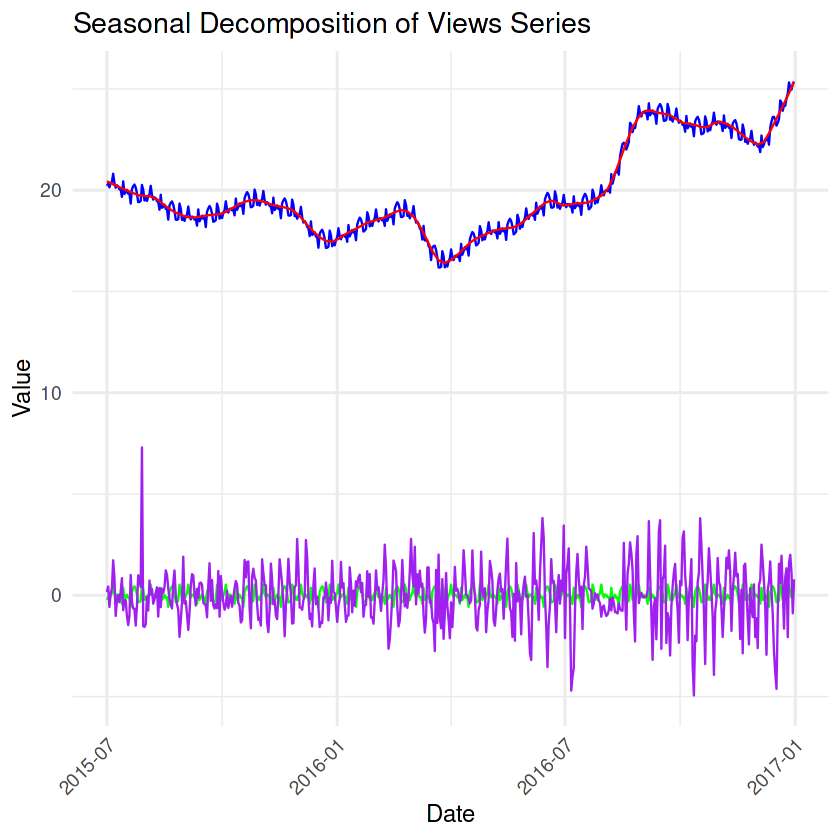

In [20]:
# Plot the decomposed data
ggplot(decomposed_df, aes(x = Date)) +
  geom_line(aes(y = Observed), color = "blue") +
  geom_line(aes(y = Seasonal), color = "green") +
  geom_line(aes(y = Trend), color = "red") +
  geom_line(aes(y = Remainder), color = "purple") +
  labs(
    title = "Seasonal Decomposition of Views Series",
    x = "Date",
    y = "Value",
    color = "Components"
  ) +
  scale_color_manual(values = c("blue", "green", "red", "purple")) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


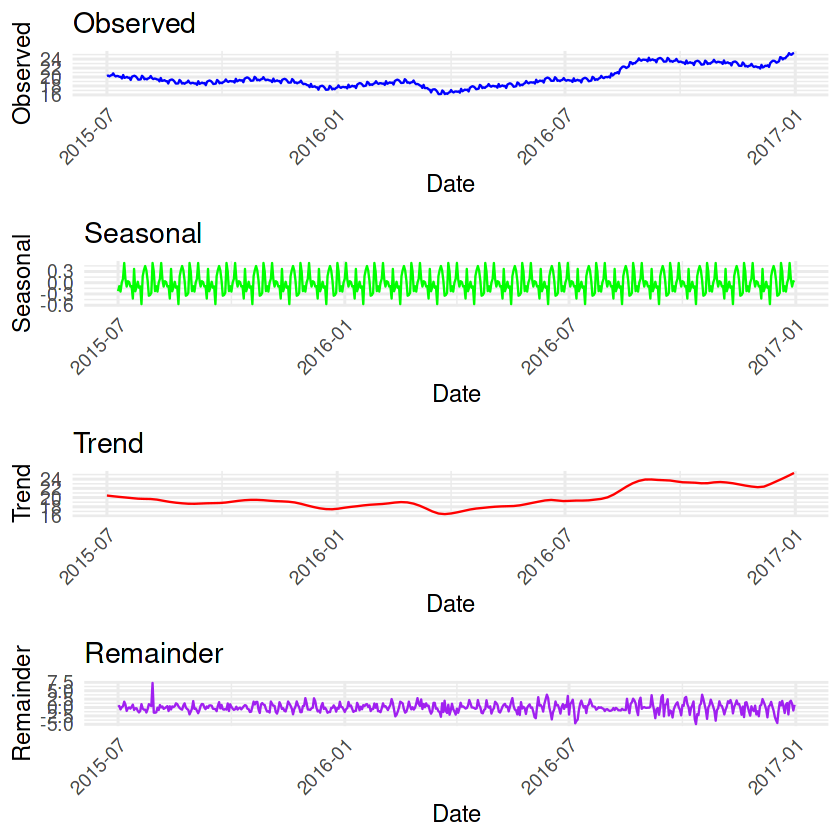

In [21]:
# Install and load necessary libraries
# install.packages("gridExtra")

library(data.table)
library(ggplot2)
library(isotree)
library(zoo)
library(forecast)
library(xts)
library(gridExtra)

# Convert to time series object
ts_views <- ts(top_page_df$Views, frequency = 30)

# Perform STL decomposition
ts_decomposition <- stl(ts_views, s.window = "periodic")

# Create decomposed data frame
decomposed_df <- data.table(
  Date = top_page_df$Date,
  Observed = ts_decomposition$time.series[, "seasonal"] + ts_decomposition$time.series[, "trend"],
  Seasonal = ts_decomposition$time.series[, "seasonal"],
  Trend = ts_decomposition$time.series[, "trend"],
  Remainder = ts_decomposition$time.series[, "remainder"]
)

# Create individual plots
observed_plot <- ggplot(decomposed_df, aes(x = Date, y = Observed)) +
  geom_line(color = "blue") +
  labs(title = "Observed", x = "Date", y = "Observed") +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

seasonal_plot <- ggplot(decomposed_df, aes(x = Date, y = Seasonal)) +
  geom_line(color = "green") +
  labs(title = "Seasonal", x = "Date", y = "Seasonal") +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

trend_plot <- ggplot(decomposed_df, aes(x = Date, y = Trend)) +
  geom_line(color = "red") +
  labs(title = "Trend", x = "Date", y = "Trend") +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

remainder_plot <- ggplot(decomposed_df, aes(x = Date, y = Remainder)) +
  geom_line(color = "purple") +
  labs(title = "Remainder", x = "Date", y = "Remainder") +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Arrange the plots in a 4-row layout
grid.arrange(observed_plot, seasonal_plot, trend_plot, remainder_plot, ncol = 1)


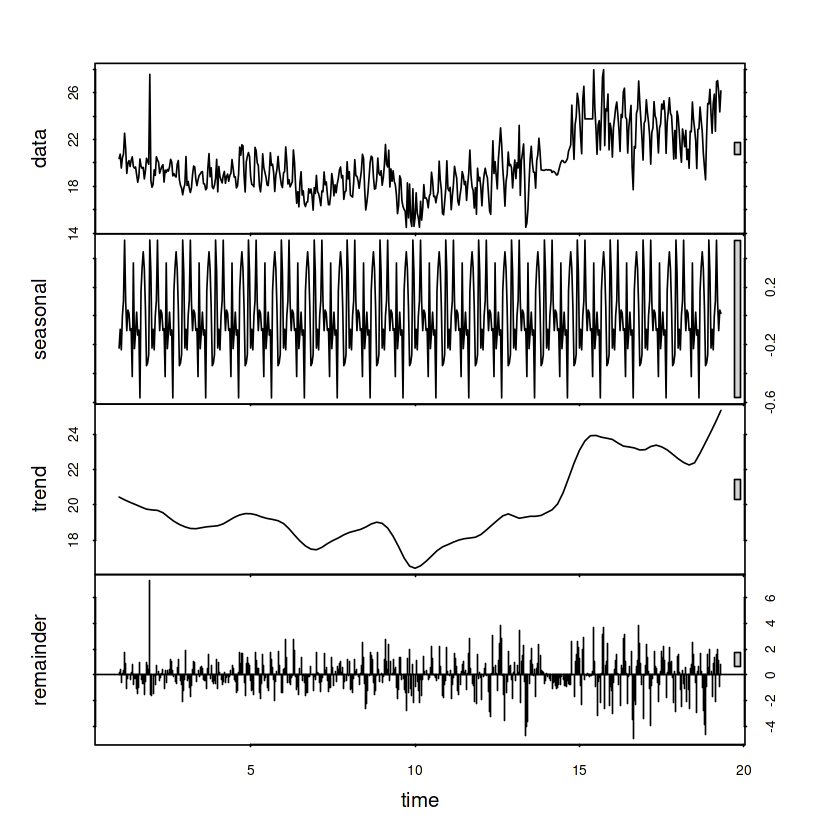

In [22]:
library(data.table)
library(ggplot2)
library(isotree)
library(zoo)
library(forecast)

# Convert to time series object
ts_views <- ts(top_page_df$Views, frequency = 30)

# Perform seasonal decomposition
ts_decomposition <- stl(ts_views, s.window = "periodic")

# Plot the decomposition
plot(ts_decomposition)


## ADF

In [23]:
# Install the tseries package if not already installed
# install.packages("tseries")

library(tseries)


In [24]:
# Perform the Augmented Dickey-Fuller test
adf_test <- adf.test(top_page_df$Views)

# Print the test result
print(adf_test)



	Augmented Dickey-Fuller Test

data:  top_page_df$Views
Dickey-Fuller = -2.2839, Lag order = 8, p-value = 0.4581
alternative hypothesis: stationary



## Differencing

In [25]:
# Difference the data to make it stationary
top_page_stationary_df <- data.table(
  Date = top_page_df$Date[-1],
  Views = diff(top_page_df$Views)
)


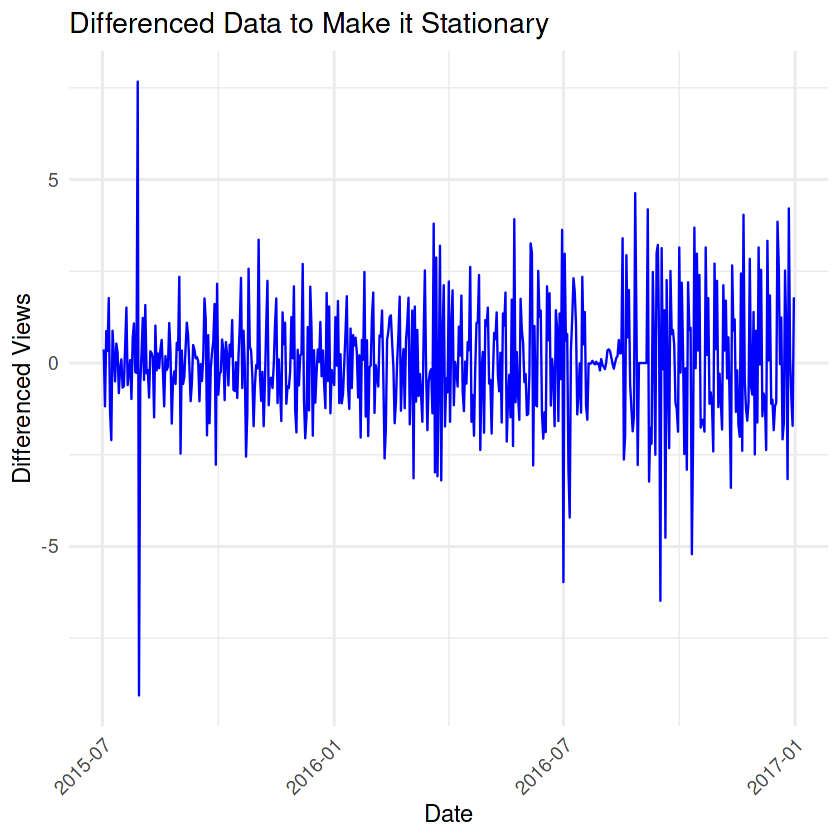

In [26]:
# Plot the stationary data
ggplot(top_page_stationary_df, aes(x = Date, y = Views)) +
  geom_line(color = "blue") +
  labs(
    title = "Differenced Data to Make it Stationary",
    x = "Date",
    y = "Differenced Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## ADF after differencing

In [27]:
# Perform the Augmented Dickey-Fuller test on stationary data
adf_test_stationary <- adf.test(top_page_stationary_df$Views)

# Print the test result
print(adf_test_stationary)


Warning message in adf.test(top_page_stationary_df$Views):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  top_page_stationary_df$Views
Dickey-Fuller = -10.375, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary



## ACF after differencing

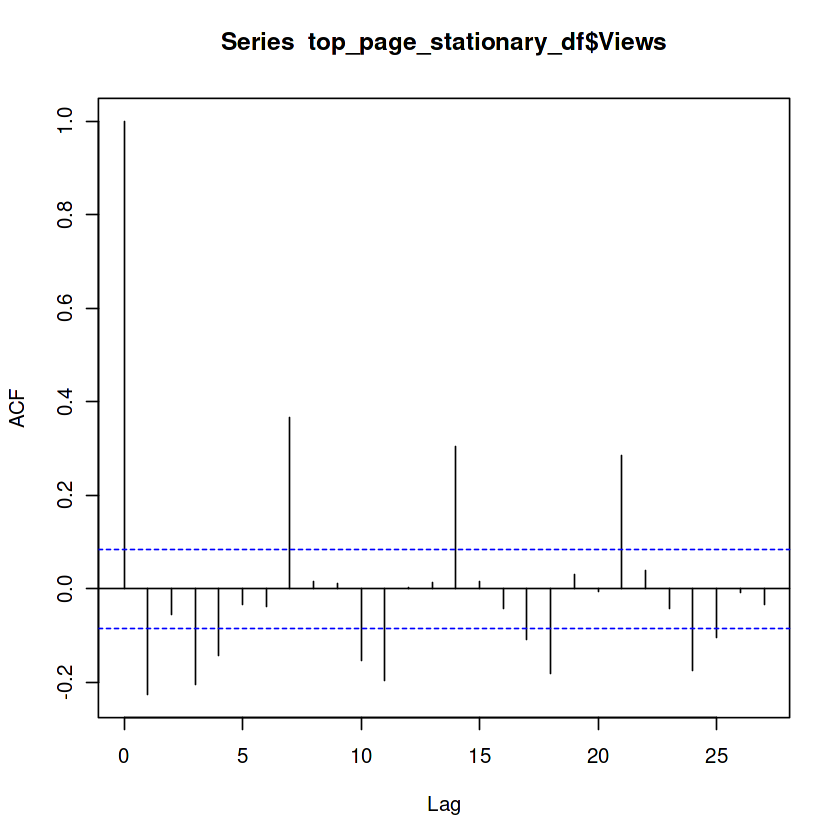

In [28]:
# simple acf function

acf(top_page_stationary_df$Views)

# Preparing data for modeling

In [29]:
# Define the training set (data up to and including September 2016)
train <- top_page_df[Date <= as.Date("2016-09-30")]

# Define the testing set (data from October 2016 onwards)
test <- top_page_df[Date >= as.Date("2016-10-01")]


In [30]:
dim(train)
dim(test)

[1] 458   2

[1] 92  2

Classes ‘data.table’ and 'data.frame':	550 obs. of  2 variables:
 $ Date : Date, format: "2015-07-01" "2015-07-02" ...
 $ Views: num  20.4 20.8 19.6 20.4 20.8 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Date,Views
<date>,<dbl>
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77
2015-07-06,22.54


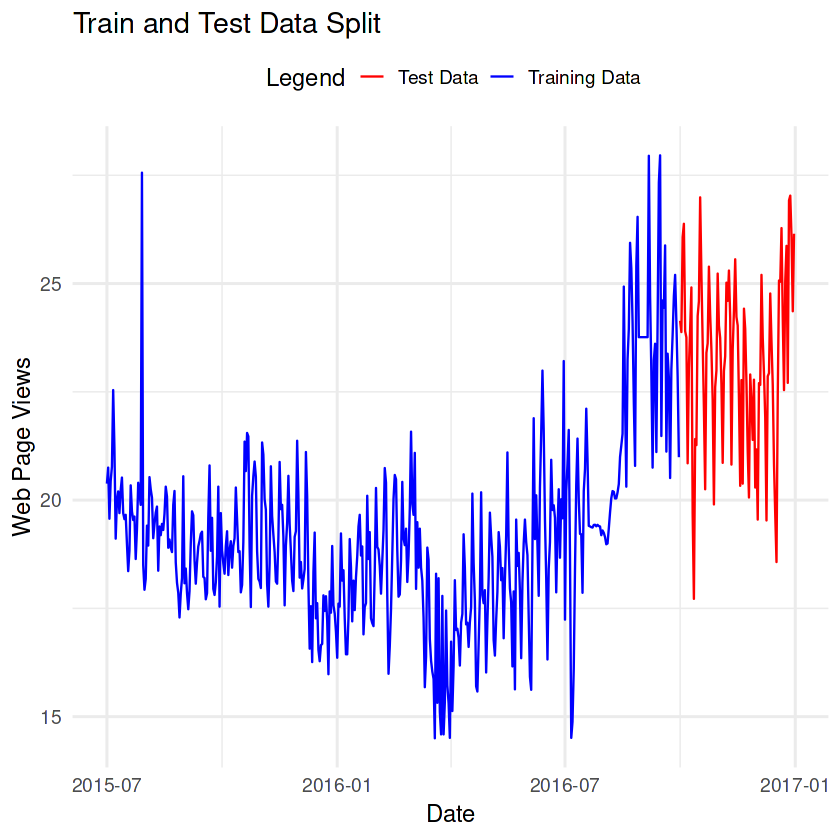

In [31]:
# Install required package if not already installed
if (!require(ggplot2)) install.packages("ggplot2")

# Load the ggplot2 package
library(ggplot2)

# Assuming `top_page_df` is your data frame with Date and Views columns
str(top_page_df)
head(top_page_df)

# Define the training and testing sets
train <- top_page_df[top_page_df$Date <= as.Date("2016-09-30"), ]
test <- top_page_df[top_page_df$Date >= as.Date("2016-10-01"), ]

# Create the plot
ggplot() +
  geom_line(data = train, aes(x = Date, y = Views, color = "Training Data")) +
  geom_line(data = test, aes(x = Date, y = Views, color = "Test Data")) +
  labs(
    title = "Train and Test Data Split",
    x = "Date",
    y = "Web Page Views"
  ) +
  scale_color_manual(values = c("Training Data" = "blue", "Test Data" = "red")) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top") +
  guides(colour = guide_legend("Legend"))


## ACF and PACF of train data

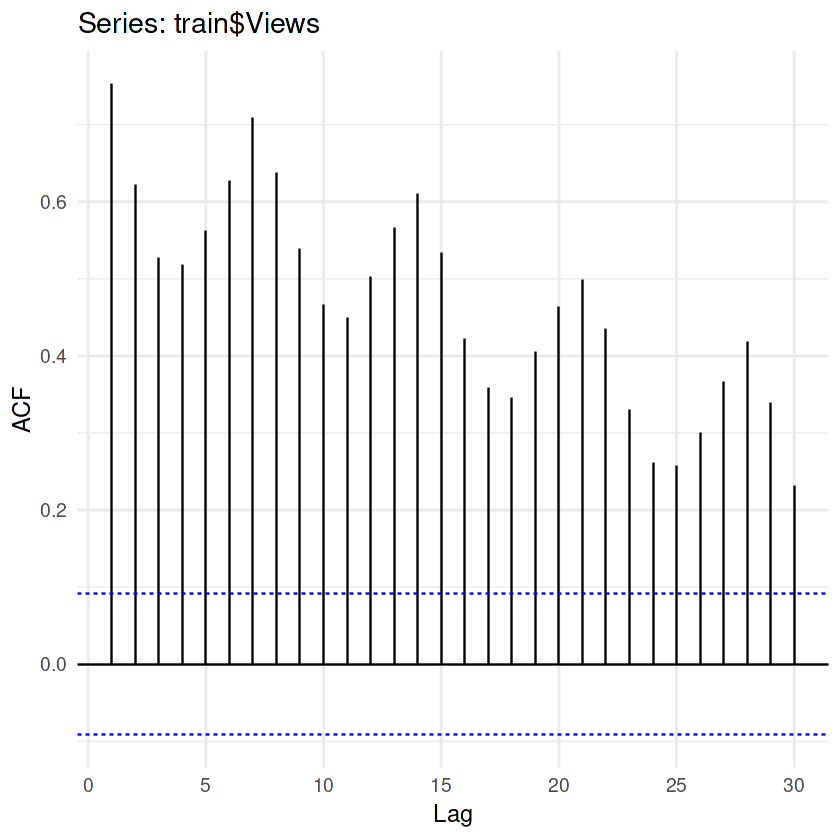

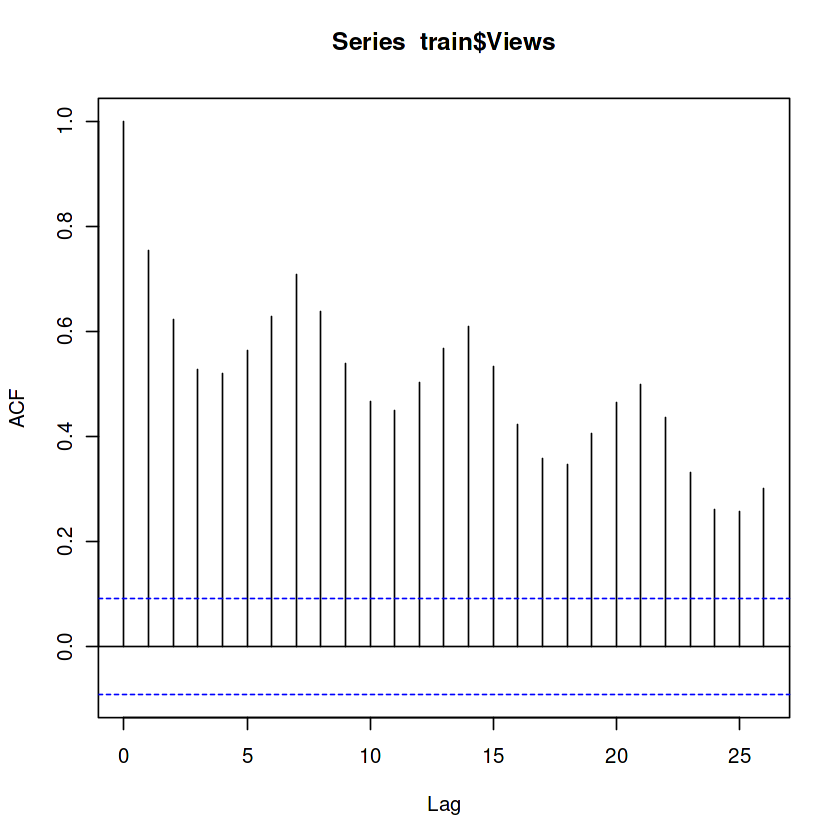

In [32]:
# Plot the ACF for the training data
acf_plot_train <- ggAcf(train$Views, lag.max = 30) +
  theme_minimal(base_size = 14)

# Show the plot
print(acf_plot_train)

acf(train$Views)

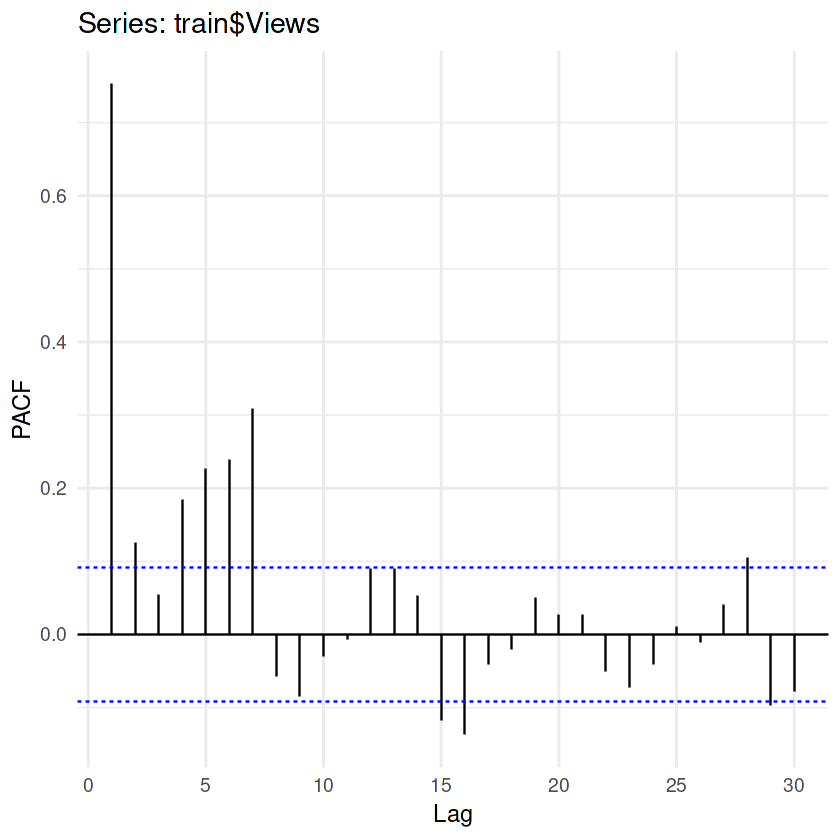

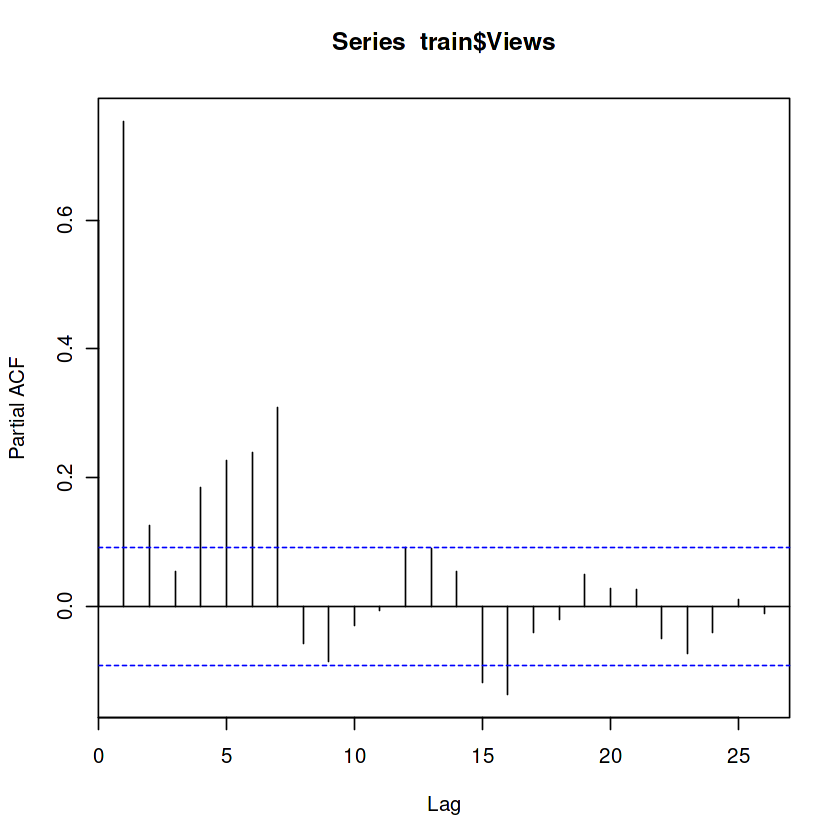

In [33]:
# Plot the PACF for the training data
pacf_plot_train <- ggPacf(train$Views, lag.max = 30) +
  theme_minimal(base_size = 14)

# Show the plot
print(pacf_plot_train)

pacf(train$Views)

# ARMA model

## Finding p, d, q values

In [34]:
library(forecast)

# Initialize an empty list to store AIC and BIC values
aic_bic_values <- data.frame(p = integer(), q = integer(), AIC = numeric(), BIC = numeric(), stringsAsFactors = FALSE)

# Loop through different values of p and q
for (p in 0:6) {
  for (q in 0:6) {
    try({
      # Fit ARMA(p, q) model
      model <- Arima(train$Views, order = c(p, 0, q))
      # Store the AIC and BIC values
      aic_bic_values <- rbind(aic_bic_values, data.frame(p = p, q = q, AIC = AIC(model), BIC = BIC(model)))
    }, silent = TRUE)
  }
}

# Print the AIC and BIC values
print(aic_bic_values)


   p q      AIC      BIC
1  0 0 2020.820 2029.074
2  0 1 1802.136 1814.517
3  0 2 1705.093 1721.600
4  0 3 1684.101 1704.735
5  0 4 1663.029 1687.790
6  0 5 1658.072 1686.960
7  0 6 1653.485 1686.500
8  1 0 1638.383 1650.764
9  1 1 1629.487 1645.995
10 1 2 1580.803 1601.437
11 1 3 1572.980 1597.741
12 1 4 1568.756 1597.644
13 1 5 1652.971 1685.986
14 1 6 1558.711 1595.853
15 2 0 1632.541 1649.048
16 2 1 1578.975 1599.610
17 2 2 1578.571 1603.333
18 2 3 1573.725 1602.613
19 2 4 1575.902 1608.917
20 2 5 1563.384 1600.526
21 2 6 1563.144 1604.413
22 3 0 1632.953 1653.587
23 3 1 1575.705 1600.467
24 3 2 1581.483 1610.371
25 3 3 1573.575 1606.590
26 3 4 1568.642 1605.784
27 3 5 1558.195 1599.464
28 3 6 1560.127 1605.522
29 4 0 1617.517 1642.279
30 4 1 1553.644 1582.532
31 4 2 1537.474 1570.489
32 4 3 1575.269 1612.411
33 4 4 1570.621 1611.889
34 4 6 1565.226 1614.749
35 5 0 1592.358 1621.246
36 5 1 1542.984 1575.999
37 5 3 1538.512 1579.781
38 5 4 1577.217 1622.612
39 6 0 1561.921 1594.936


In [35]:
# Load necessary library
library(dplyr)

# Create a data frame from the stored AIC and BIC values
aic_bic_df <- aic_bic_values %>% 
  arrange(AIC, BIC)

# Print the sorted data frame
print(aic_bic_df)



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is not affected. It's protected by R's namespace mechanism #
# Set `options(xts.warn_dplyr_breaks_lag = FALSE)` to suppress this warning.  #
#                                      


Attaching package: ‘dplyr’




The following object is masked from ‘package:gridExtra’:

    combine




The following objects are masked from ‘package:xts’:

    first, last




The following objects are masked from ‘package:data.table’:

    between, first, last




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




   p q      AIC      BIC
1  6 5 1475.892 1529.541
2  6 6 1477.677 1535.454
3  6 2 1497.858 1539.126
4  6 3 1503.678 1549.073
5  6 1 1533.601 1570.743
6  4 2 1537.474 1570.489
7  5 3 1538.512 1579.781
8  6 4 1542.459 1591.981
9  5 1 1542.984 1575.999
10 4 1 1553.644 1582.532
11 3 5 1558.195 1599.464
12 1 6 1558.711 1595.853
13 3 6 1560.127 1605.522
14 6 0 1561.921 1594.936
15 2 6 1563.144 1604.413
16 2 5 1563.384 1600.526
17 4 6 1565.226 1614.749
18 3 4 1568.642 1605.784
19 1 4 1568.756 1597.644
20 4 4 1570.621 1611.889
21 1 3 1572.980 1597.741
22 3 3 1573.575 1606.590
23 2 3 1573.725 1602.613
24 4 3 1575.269 1612.411
25 3 1 1575.705 1600.467
26 2 4 1575.902 1608.917
27 5 4 1577.217 1622.612
28 2 2 1578.571 1603.333
29 2 1 1578.975 1599.610
30 1 2 1580.803 1601.437
31 3 2 1581.483 1610.371
32 5 0 1592.358 1621.246
33 4 0 1617.517 1642.279
34 1 1 1629.487 1645.995
35 2 0 1632.541 1649.048
36 3 0 1632.953 1653.587
37 1 0 1638.383 1650.764
38 1 5 1652.971 1685.986
39 0 6 1653.485 1686.500


In [36]:
# Extract the best p and q values based on the lowest AIC
best_p <- aic_bic_df$p[1]
best_q <- aic_bic_df$q[1]

# Fit the ARMA model with the best p and q values
best_model <- Arima(train$Views, order = c(best_p, 0, best_q))

# Print the model summary
summary(best_model)


Series: train$Views 
ARIMA(6,0,5) with non-zero mean 

Coefficients:
         ar1     ar2      ar3      ar4     ar5      ar6      ma1      ma2
      0.9587  0.0408  -0.3642  -0.4732  1.0087  -0.1897  -0.6003  -0.1053
s.e.  0.0940  0.1314   0.1141   0.1208  0.1039   0.0653   0.0818   0.1027
         ma3     ma4      ma5     mean
      0.2558  0.6753  -0.7442  19.9735
s.e.  0.0811  0.0871   0.0611   1.2107

sigma^2 = 1.392:  log likelihood = -724.95
AIC=1475.89   AICc=1476.71   BIC=1529.54

Training set error measures:
                       ME     RMSE       MAE        MPE     MAPE      MASE
Training set -0.004616943 1.164442 0.8179527 -0.3863789 4.242079 0.7460671
                    ACF1
Training set 0.006472488

## Prediction using ARMA

In [37]:
# Generate predictions for the last 30 points of the training data
forecast <- forecast(best_model, h = 30)
forecast_mean <- forecast$mean
confidence_interval <- forecast$lower
confidence_interval_upper <- forecast$upper


Warning message in geom_line(data = train[(nrow(train) - 29):nrow(train), ], aes(x = Date, :
“Ignoring unknown parameters: `label`”


Warning message in geom_line(aes(x = tail(train$Date, 30), y = forecast_mean), color = "red", :
“Ignoring unknown parameters: `label`”


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


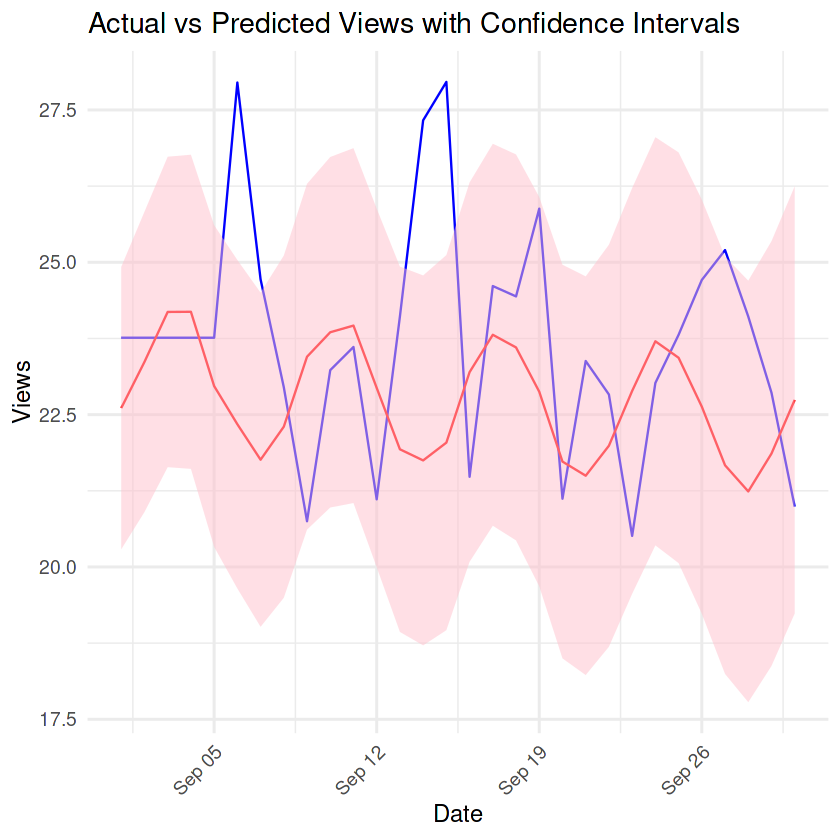

In [38]:
# Plot the actual vs predicted values with confidence intervals
ggplot() +
  geom_line(data = train[(nrow(train)-29):nrow(train), ], aes(x = Date, y = Views), color = "blue", label = "Actual Value") +
  geom_line(aes(x = tail(train$Date, 30), y = forecast_mean), color = "red", label = "Prediction") +
  geom_ribbon(aes(x = tail(train$Date, 30), ymin = confidence_interval[, 2], ymax = confidence_interval_upper[, 2]), fill = "pink", alpha = 0.5) +
  labs(
    title = "Actual vs Predicted Views with Confidence Intervals",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Actual Value" = "blue", "Prediction" = "red")) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend("Legend"))


## Forecasting using ARMA model 

In [39]:
# Generate predictions for the last 30 points of the training data
forecast <- forecast(best_model, h = 30)
forecast_mean <- forecast$mean
confidence_interval <- forecast$lower
confidence_interval_upper <- forecast$upper


In [40]:
# Create a data frame with forecasted values and confidence intervals
arma_forecast_df <- data.table(
  Date = test$Date,
  Views = forecast_mean,
  lower_views = confidence_interval[, 2],
  upper_views = confidence_interval_upper[, 2]
)


Warning message:
“Item 2 has 30 rows but longest item has 92; recycled with remainder.”


Warning message:
“Item 3 has 30 rows but longest item has 92; recycled with remainder.”


Warning message:
“Item 4 has 30 rows but longest item has 92; recycled with remainder.”


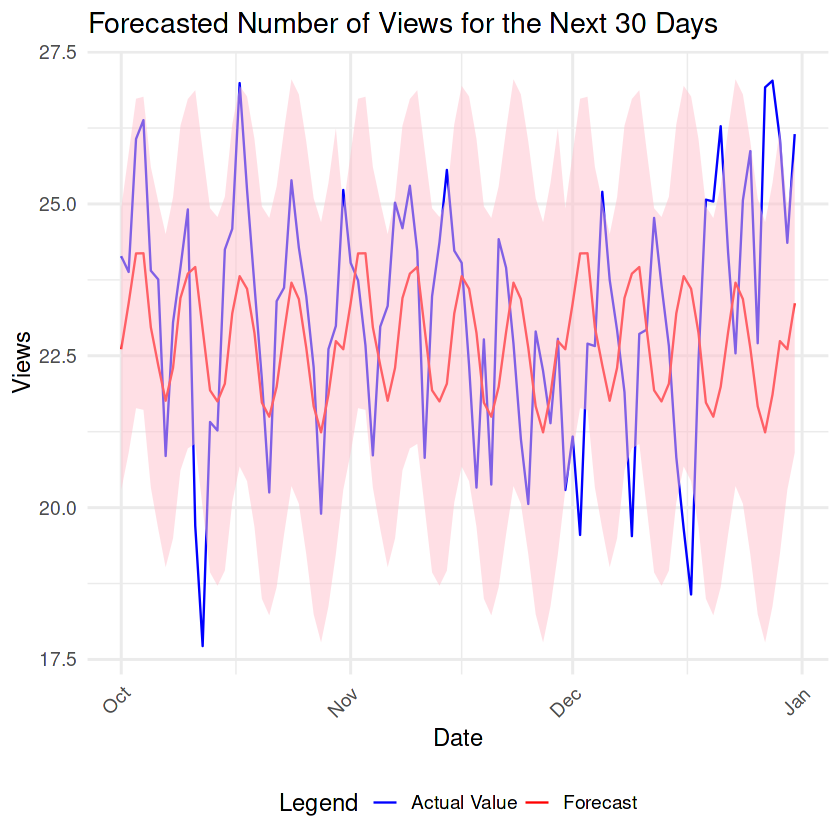

In [41]:
# Plot the actual vs predicted values with confidence intervals
ggplot() +
  geom_line(data = test, aes(x = Date, y = Views, color = "Actual Value")) +
  geom_line(data = arma_forecast_df, aes(x = Date, y = Views, color = "Forecast")) +
  geom_ribbon(data = arma_forecast_df, aes(x = Date, ymin = lower_views, ymax = upper_views), fill = "pink", alpha = 0.5) +
  labs(
    title = "Forecasted Number of Views for the Next 30 Days",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Actual Value" = "blue", "Forecast" = "red")) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend("Legend"))


## Calculate RMSE

In [42]:
summary(forecast)



Forecast method: ARIMA(6,0,5) with non-zero mean

Model Information:
Series: train$Views 
ARIMA(6,0,5) with non-zero mean 

Coefficients:
         ar1     ar2      ar3      ar4     ar5      ar6      ma1      ma2
      0.9587  0.0408  -0.3642  -0.4732  1.0087  -0.1897  -0.6003  -0.1053
s.e.  0.0940  0.1314   0.1141   0.1208  0.1039   0.0653   0.0818   0.1027
         ma3     ma4      ma5     mean
      0.2558  0.6753  -0.7442  19.9735
s.e.  0.0811  0.0871   0.0611   1.2107

sigma^2 = 1.392:  log likelihood = -724.95
AIC=1475.89   AICc=1476.71   BIC=1529.54

Error measures:
                       ME     RMSE       MAE        MPE     MAPE      MASE
Training set -0.004616943 1.164442 0.8179527 -0.3863789 4.242079 0.7460671
                    ACF1
Training set 0.006472488

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
459       22.60756 21.09207 24.12306 20.28981 24.92531
460       23.36512 21.75384 24.97640 20.90088 25.82936
461       24.18521 22.51932 25.85110 21.637

In [43]:
length(forecast_mean)
length(test$Views)


[1] 30

[1] 92

In [44]:
# Ensure lengths match by trimming the test set
test_trimmed <- test[1:length(forecast_mean), ]

# Calculate RMSE for the ARMA model's forecasts
arma_rmse_value <- sqrt(mean((forecast_mean - test_trimmed$Views)^2))
print(paste("RMSE: ", arma_rmse_value))


[1] "RMSE:  1.77041676004366"


# ARIMA model

## Find and store AIC/BIC values

In [45]:
library(forecast)

# Initialize an empty list to store AIC and BIC values
arima_aic_bic <- data.frame(p = integer(), q = integer(), AIC = numeric(), BIC = numeric(), stringsAsFactors = FALSE)

# Loop through different values of p and q
for (p in 0:6) {
  for (q in 0:6) {
    try({
      # Fit ARIMA(p,1,q) model
      arima_model <- Arima(train$Views, order = c(p, 1, q))
      # Store the AIC and BIC values
      arima_aic_bic <- rbind(arima_aic_bic, data.frame(p = p, q = q, AIC = AIC(arima_model), BIC = BIC(arima_model)))
    }, silent = TRUE)
  }
}

# Convert to a data frame and sort by AIC and BIC
arima_aic_bic_df <- arima_aic_bic %>% arrange(AIC, BIC)

# Print the sorted data frame
print(arima_aic_bic_df)


   p q      AIC      BIC
1  5 5 1469.472 1514.844
2  3 3 1469.595 1498.468
3  2 4 1470.370 1499.243
4  6 5 1470.927 1520.423
5  5 6 1471.521 1521.017
6  4 4 1472.247 1509.369
7  6 6 1473.055 1526.676
8  2 6 1473.166 1510.288
9  5 3 1473.194 1510.316
10 5 4 1473.950 1515.197
11 3 4 1479.628 1512.625
12 6 3 1498.928 1540.175
13 5 2 1499.301 1532.298
14 6 4 1500.169 1545.540
15 6 0 1500.305 1529.178
16 6 1 1502.180 1535.177
17 6 2 1502.840 1539.962
18 5 1 1527.667 1556.539
19 4 2 1528.401 1557.274
20 3 2 1532.431 1557.179
21 4 3 1533.507 1566.504
22 4 1 1536.768 1561.516
23 3 1 1547.200 1567.824
24 1 6 1552.208 1585.206
25 1 4 1552.827 1577.575
26 1 5 1553.056 1581.929
27 2 5 1553.649 1586.646
28 0 6 1553.657 1582.530
29 0 5 1554.796 1579.544
30 5 0 1559.780 1584.528
31 0 4 1562.376 1582.999
32 0 3 1566.224 1582.723
33 2 3 1566.911 1591.659
34 1 3 1566.998 1587.622
35 2 1 1569.074 1585.572
36 1 2 1571.889 1588.388
37 1 1 1572.270 1584.645
38 0 2 1574.272 1586.646
39 2 2 1574.767 1595.390


## Fit the Best ARIMA Model and Forecast

In [46]:
# Extract the best p and q values based on the lowest AIC
best_p <- arima_aic_bic_df$p[1]
best_q <- arima_aic_bic_df$q[1]

# Fit the ARIMA model with the best p, d, and q values
best_arima_model <- Arima(train$Views, order = c(best_p, 1, best_q))

# Generate forecasts for the test period
arima_forecasts <- forecast(best_arima_model, h = nrow(test))
arima_forecast_values_mean <- arima_forecasts$mean
arima_conf_interval <- arima_forecasts$lower
arima_conf_interval_upper <- arima_forecasts$upper


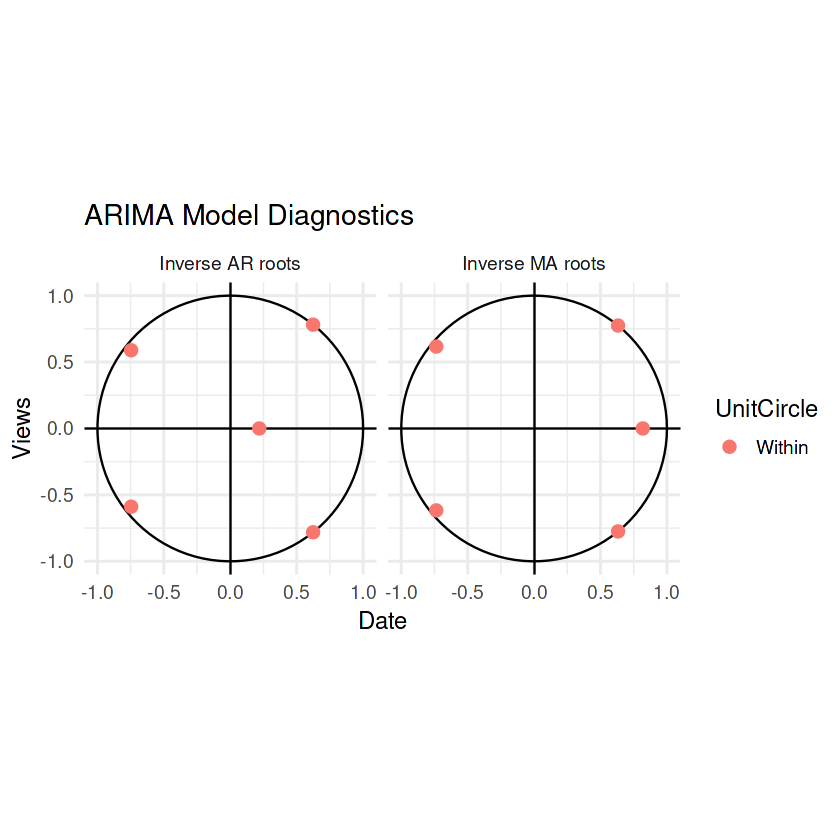


	Ljung-Box test

data:  Residuals from ARIMA(5,1,5)
Q* = 15.685, df = 3, p-value = 0.001315

Model df: 10.   Total lags used: 13



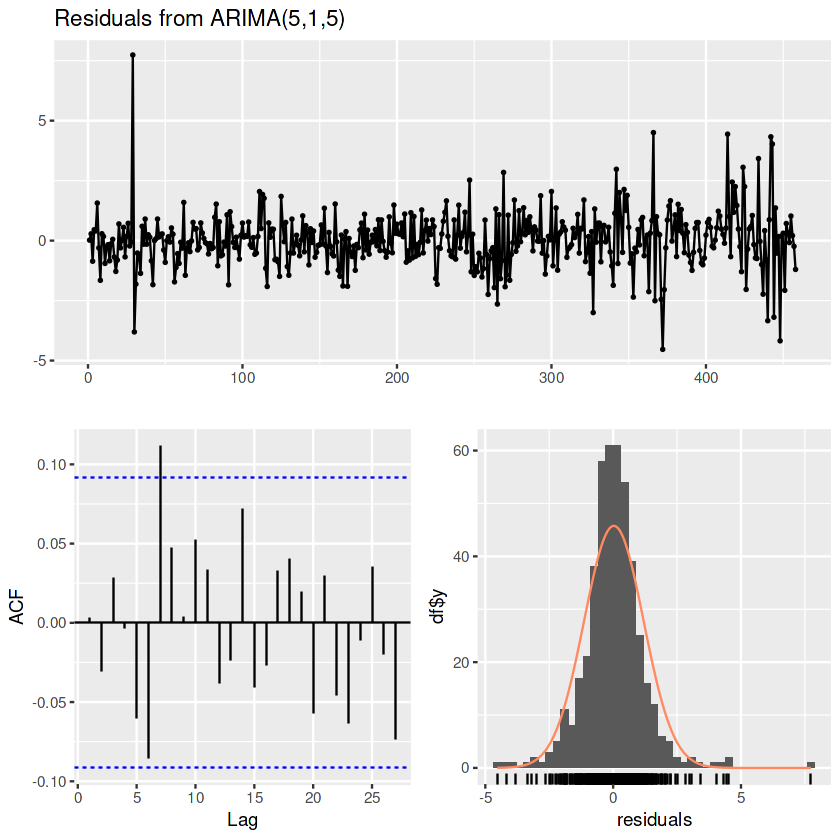

In [47]:
# Plot diagnostics for the ARIMA model
autoplot(best_arima_model) +
  labs(
    title = "ARIMA Model Diagnostics",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14)

checkresiduals(best_arima_model)

## RMSE

In [48]:
# Ensure lengths match by trimming the test set
test_trimmed <- test[1:length(arima_forecast_values_mean), ]

# Calculate RMSE for the ARIMA model's forecasts
arima_rmse_value <- sqrt(mean((arima_forecast_values_mean - test_trimmed$Views)^2))
print(paste("RMSE: ", arima_rmse_value))


[1] "RMSE:  1.72040926547375"


In [49]:
# Generate the summary of the ARIMA model
summary(best_arima_model)

Series: train$Views 
ARIMA(5,1,5) 

Coefficients:
          ar1     ar2      ar3      ar4     ar5      ma1      ma2     ma3
      -0.0274  0.0122  -0.3557  -0.8233  0.1970  -0.6101  -0.1091  0.2565
s.e.   0.0917  0.0712   0.0544   0.0820  0.0651   0.0789   0.1016  0.0813
         ma4      ma5
      0.6714  -0.7543
s.e.  0.0868   0.0593

sigma^2 = 1.392:  log likelihood = -723.74
AIC=1469.47   AICc=1470.07   BIC=1514.84

Training set error measures:
                     ME     RMSE       MAE        MPE     MAPE      MASE
Training set 0.02727246 1.165526 0.8168586 -0.1924519 4.228769 0.7450691
                    ACF1
Training set 0.003629653

## Prediction using ARIMA

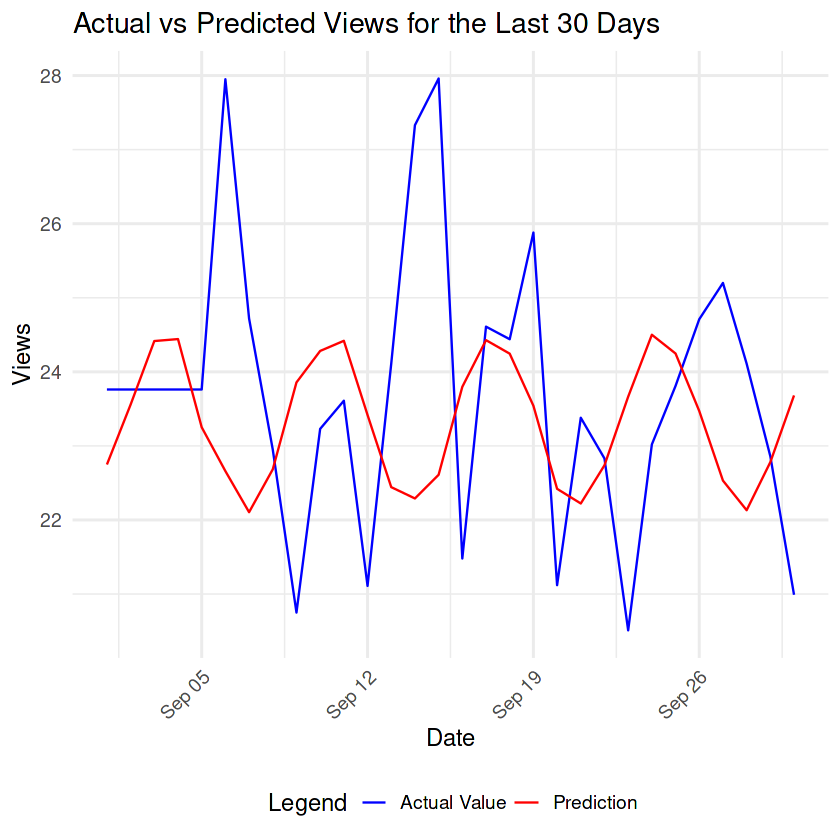

In [50]:
# Generate forecasts for the last 30 points of the training data
forecast <- forecast(best_arima_model, h = 30)
forecast_mean <- forecast$mean

# Create a data frame for the last 30 points of the training data and forecasted values
train_last_30 <- train[(nrow(train)-29):nrow(train), ]
forecast_last_30 <- data.table(
  Date = train_last_30$Date,
  Views = forecast_mean
)

# Plot the actual vs predicted values for the last 30 points of the training data
ggplot() +
  geom_line(data = train_last_30, aes(x = Date, y = Views, color = "Actual Value")) +
  geom_line(data = forecast_last_30, aes(x = Date, y = Views, color = "Prediction")) +
  labs(
    title = "Actual vs Predicted Views for the Last 30 Days",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Actual Value" = "blue", "Prediction" = "red")) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend("Legend"))


## Forecasting using ARIMA model

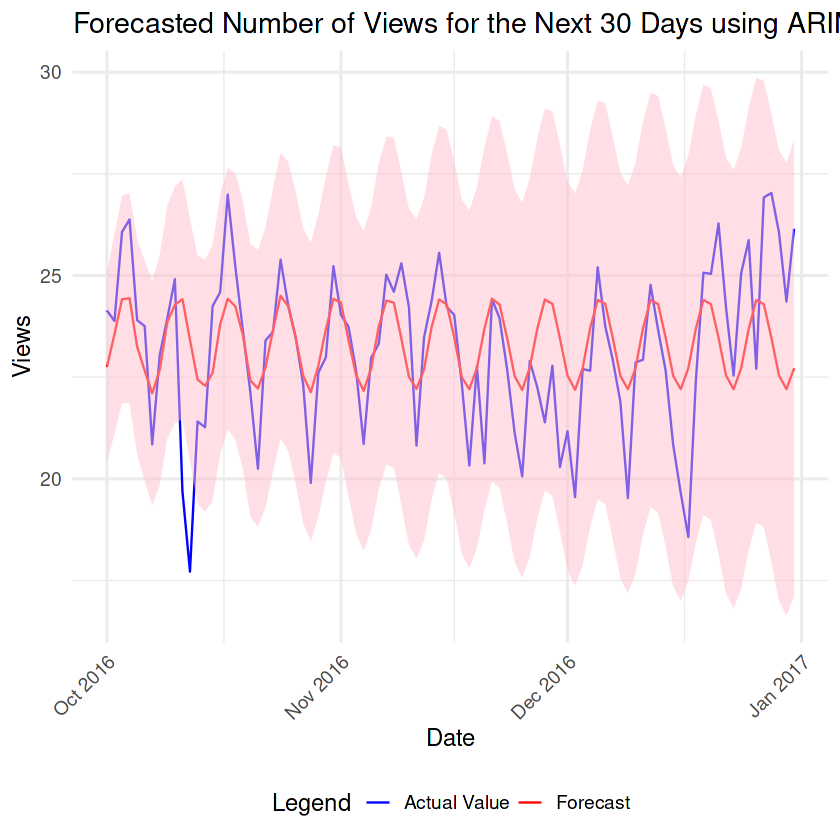

In [51]:
library(ggplot2)
library(scales)  # Make sure to load the scales package

# Create a data frame with forecasted values and confidence intervals
arima_forecast_df <- data.table(
  Date = test_trimmed$Date,
  Views = arima_forecast_values_mean,
  lower_views = arima_conf_interval[, 2],
  upper_views = arima_conf_interval_upper[, 2]
)

# Plot the actual vs predicted values with confidence intervals
ggplot() +
  geom_line(data = test_trimmed, aes(x = Date, y = Views, color = "Actual Value")) +
  geom_line(data = arima_forecast_df, aes(x = Date, y = Views, color = "Forecast")) +
  geom_ribbon(data = arima_forecast_df, aes(x = Date, ymin = lower_views, ymax = upper_views), fill = "pink", alpha = 0.5) +
  labs(
    title = "Forecasted Number of Views for the Next 30 Days using ARIMA Model",
    x = "Date",
    y = "Views"
  ) +
  scale_x_date(labels = date_format("%b %Y")) +  # This line formats the date axis to show month and year
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Actual Value" = "blue", "Forecast" = "red")) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend("Legend"))


# Exponential smoothing model

## Prediction

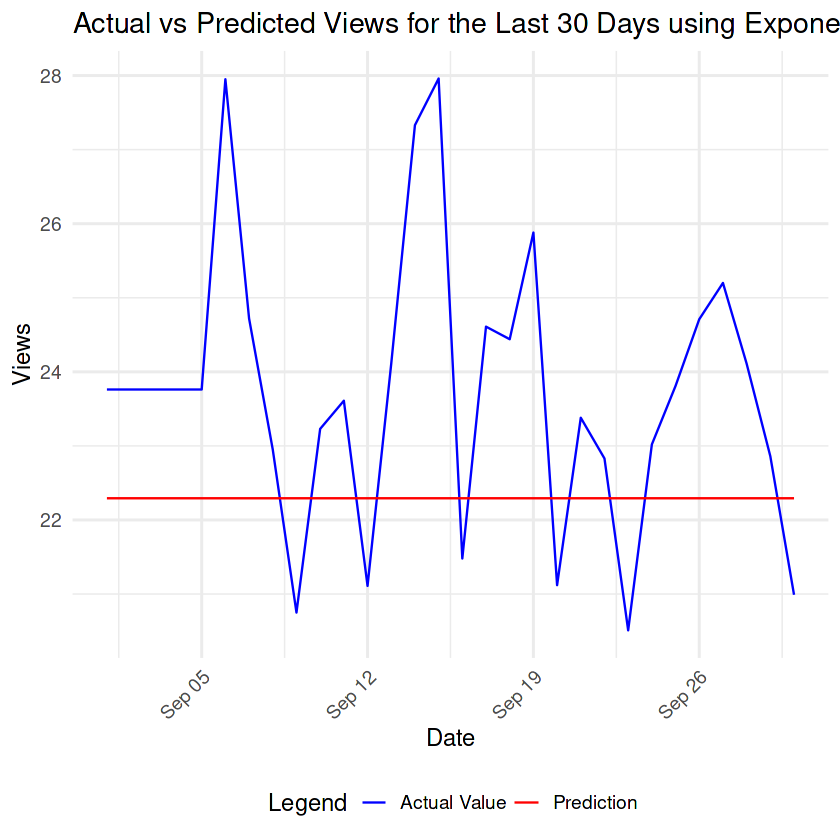

In [52]:
# Fit the Exponential Smoothing model with the forecast horizon 

exp_smoothing_model <- ses(train$Views, alpha = 0.5, h = nrow(test), initial = "optimal")

# Generate predictions for the last 30 points of the training data

exp_smoothing_prediction <- forecast(exp_smoothing_model, h = 30)
exp_smoothing_forecast_values <- exp_smoothing_prediction$mean

# Create a data frame for the last 30 points of the training data and forecasted values
train_last_30 <- train[(nrow(train)-29):nrow(train), ]
forecast_last_30 <- data.table(
  Date = train_last_30$Date,
  Views = exp_smoothing_forecast_values
)

# Plot the actual vs predicted values for the last 30 points of the training data
ggplot() +
  geom_line(data = train_last_30, aes(x = Date, y = Views, color = "Actual Value")) +
  geom_line(data = forecast_last_30, aes(x = Date, y = Views, color = "Prediction")) +
  labs(
    title = "Actual vs Predicted Views for the Last 30 Days using Exponential Smoothing",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Actual Value" = "blue", "Prediction" = "red")) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend("Legend"))


## Forecasting

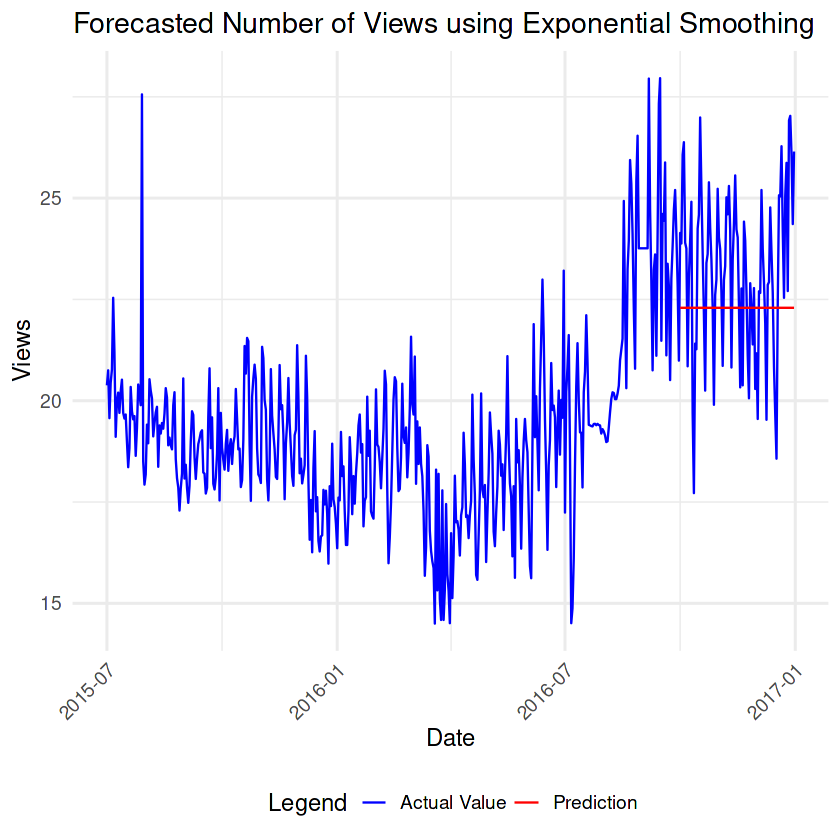

In [53]:
# Generate forecast for the test period
exp_smoothing_forecast <- forecast(exp_smoothing_model, h = nrow(test))
exp_smoothing_forecast_values_test <- exp_smoothing_forecast$mean

# Create a data frame for the forecasted values
forecast_test <- data.table(
  Date = test$Date,
  Views = exp_smoothing_forecast_values_test
)

# Plot the actual vs predicted values for the test period
ggplot() +
  geom_line(data = top_page_df, aes(x = Date, y = Views, color = "Actual Value")) +
  geom_line(data = forecast_test, aes(x = Date, y = Views, color = "Prediction")) +
  labs(
    title = "Forecasted Number of Views using Exponential Smoothing",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Actual Value" = "blue", "Prediction" = "red")) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend("Legend"))


## RMSE

In [54]:
# Calculate RMSE for the Exponential Smoothing model's forecasts
exp_smoothing_rmse <- sqrt(mean((exp_smoothing_forecast_values_test - test$Views)^2))
print(paste("RMSE: ", exp_smoothing_rmse))



[1] "RMSE:  2.18982971898603"


# Prophet

## Prepare data for Prophet

In [55]:
library(prophet)
library(data.table)
library(ggplot2)

# Prepare the data
train[, Date := as.Date(Date, format = "%Y-%m-%d")]
test[, Date := as.Date(Date, format = "%Y-%m-%d")]
train_prophet <- train[, .(ds = as.Date(Date, format = "%Y-%m-%d"), y = Views)]
test_prophet <- test[, .(ds = as.Date(Date, format = "%Y-%m-%d"), y = Views)]

# Remove any NAs (if there are any)
train_prophet <- train_prophet[!is.na(ds) & !is.na(y)]
test_prophet <- test_prophet[!is.na(ds) & !is.na(y)]

# Check the structure and first few rows of the data
str(train_prophet)
head(train_prophet)
str(test_prophet)
head(test_prophet)




Loading required package: Rcpp



Loading required package: rlang




Attaching package: ‘rlang’




The following object is masked from ‘package:data.table’:

    :=




Classes ‘data.table’ and 'data.frame':	458 obs. of  2 variables:
 $ ds: Date, format: "2015-07-01" "2015-07-02" ...
 $ y : num  20.4 20.8 19.6 20.4 20.8 ...
 - attr(*, ".internal.selfref")=<externalptr> 


ds,y
<date>,<dbl>
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77
2015-07-06,22.54


Classes ‘data.table’ and 'data.frame':	92 obs. of  2 variables:
 $ ds: Date, format: "2016-10-01" "2016-10-02" ...
 $ y : num  24.1 23.9 26.1 26.4 23.9 ...
 - attr(*, ".internal.selfref")=<externalptr> 


ds,y
<date>,<dbl>
2016-10-01,24.14000
2016-10-02,23.88000
2016-10-03,26.07000
2016-10-04,26.38000
2016-10-05,23.90138
2016-10-06,23.75679


## Fit Prophet model

In [56]:
# Fit the Prophet model
prophet_model <- prophet(train_prophet)

#prophet_model <- prophet(train_prophet, yearly.seasonality = TRUE, daily.seasonality = TRUE)

# Generate future data frame with historical and future dates
future_train <- make_future_dataframe(prophet_model, periods = nrow(test), include_history = TRUE)

# Check the structure and first few rows of the future data frame
str(future_train)
head(future_train)

Disabling yearly seasonality. Run prophet with yearly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



'data.frame':	550 obs. of  1 variable:
 $ ds: POSIXct, format: "2015-07-01" "2015-07-02" ...


,ds
,<dttm>
1,2015-07-01
2,2015-07-02
3,2015-07-03
4,2015-07-04
5,2015-07-05
6,2015-07-06


## Manually append historical values

In [57]:
# Ensure the date format is consistent
future_train$ds <- as.Date(future_train$ds, format = "%Y-%m-%d")
train_prophet$ds <- as.Date(train_prophet$ds, format = "%Y-%m-%d")

# Merge future_train with train_prophet to include the y values
future_train <- merge(future_train, train_prophet, by = "ds", all.x = TRUE)

# Handle missing values in y (if necessary, fill with 0 or other appropriate value)
#future_train[is.na(y), y := 0]

# Check the structure and first few rows of the future data frame
str(future_train)
head(future_train)


'data.frame':	550 obs. of  2 variables:
 $ ds: Date, format: "2015-07-01" "2015-07-02" ...
 $ y : num  20.4 20.8 19.6 20.4 20.8 ...


,ds,y
,<date>,<dbl>
1,2015-07-01,20.38
2,2015-07-02,20.75
3,2015-07-03,19.57
4,2015-07-04,20.44
5,2015-07-05,20.77
6,2015-07-06,22.54


## Predict using Prophet

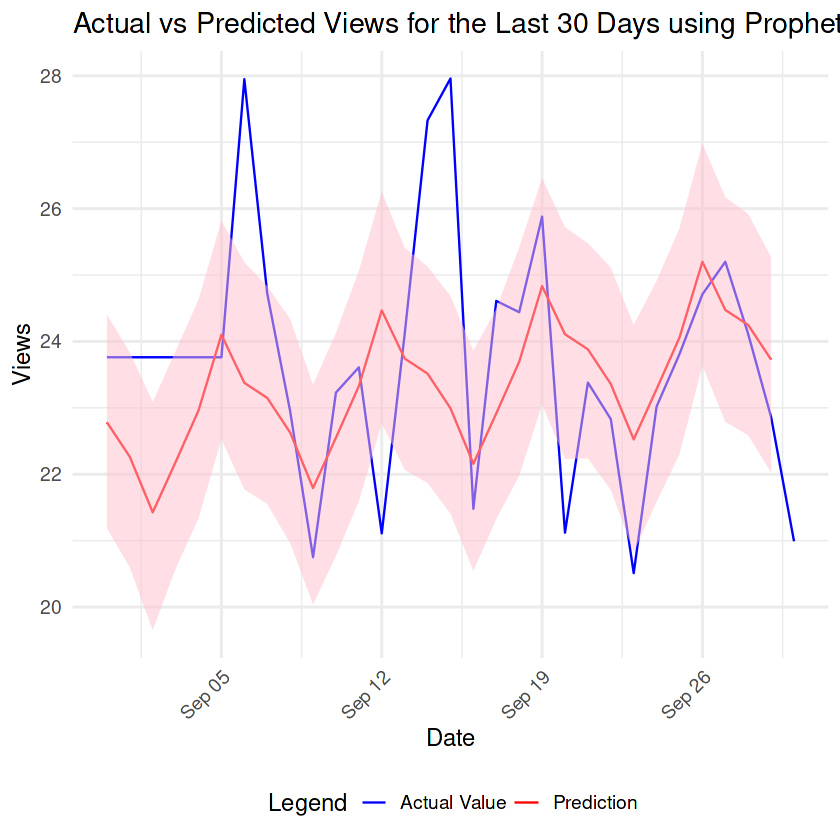

In [58]:
# Ensure the ds column is in the correct date format
future_train$ds <- as.Date(future_train$ds, format = "%Y-%m-%d")

# Predict
prophet_prediction <- predict(prophet_model, future_train)

# Ensure the ds column in the prediction is in the correct date format
prophet_prediction$ds <- as.Date(prophet_prediction$ds, format = "%Y-%m-%d")

# Extract predictions for the last 30 points of training data
prediction <- prophet_prediction[(nrow(prophet_prediction)-nrow(test)-30):(nrow(prophet_prediction)-nrow(test)-1), ]

# Plot the actual vs predicted values for the last 30 points of the training data
ggplot() +
  geom_line(data = train_prophet[(nrow(train_prophet)-30):nrow(train_prophet), ], aes(x = ds, y = y, color = "Actual Value")) +
  geom_line(data = prediction, aes(x = ds, y = yhat, color = "Prediction")) +
  geom_ribbon(data = prediction, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "pink", alpha = 0.5) +
  labs(
    title = "Actual vs Predicted Views for the Last 30 Days using Prophet",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Actual Value" = "blue", "Prediction" = "red")) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend("Legend"))

## Forecast using Prophet

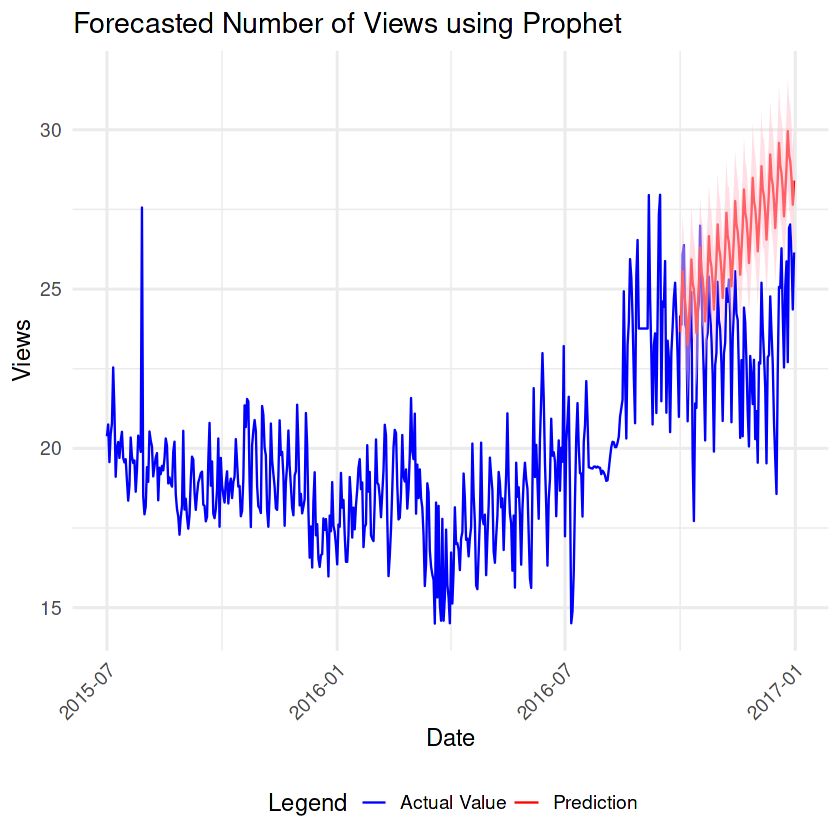

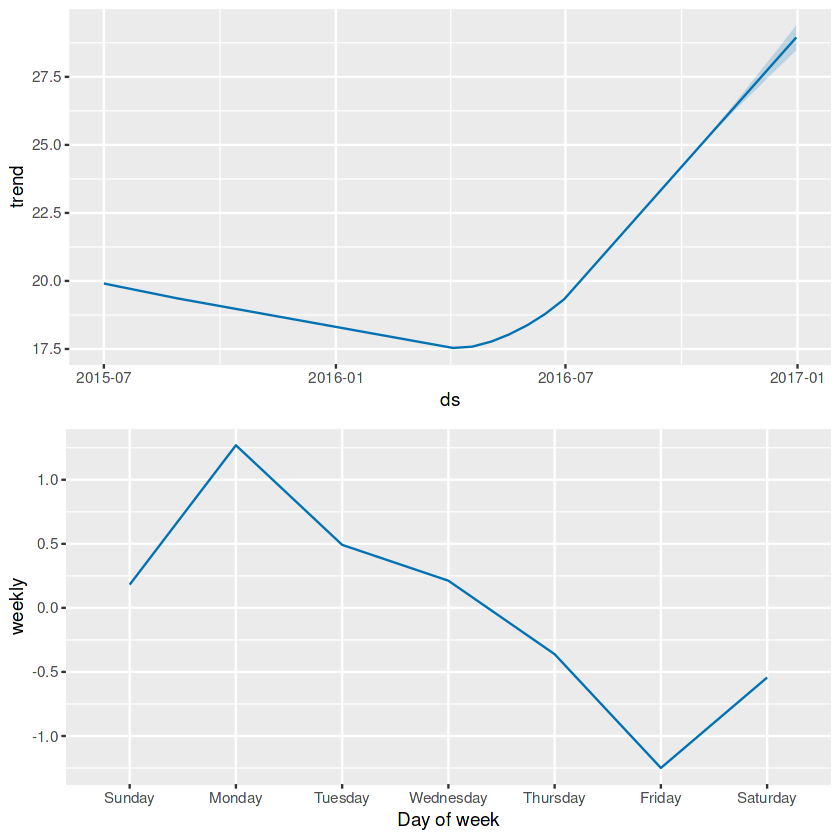

In [59]:


# Extract forecast for the test period
forecast <- prophet_prediction[(nrow(prophet_prediction)-nrow(test)+1):nrow(prophet_prediction), ]

# Plot the actual vs predicted values for the test period
ggplot() +
  geom_line(data = top_page_df, aes(x = Date, y = Views, color = "Actual Value")) +
  geom_line(data = forecast, aes(x = ds, y = yhat, color = "Prediction")) +
  geom_ribbon(data = forecast, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "pink", alpha = 0.5) +
  labs(
    title = "Forecasted Number of Views using Prophet",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Actual Value" = "blue", "Prediction" = "red")) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend("Legend"))

# Plot Prophet components
prophet_plot_components(prophet_model, prophet_prediction)



## RMSE of Prophet

In [60]:
# Extract forecasted values and actual values
forecasted_values <- forecast$yhat
actual_values <- test$Views

# Calculate RMSE
prophet_rmse <- sqrt(mean((forecasted_values - actual_values)^2))
print(paste("RMSE: ", prophet_rmse))



[1] "RMSE:  3.98593575054984"


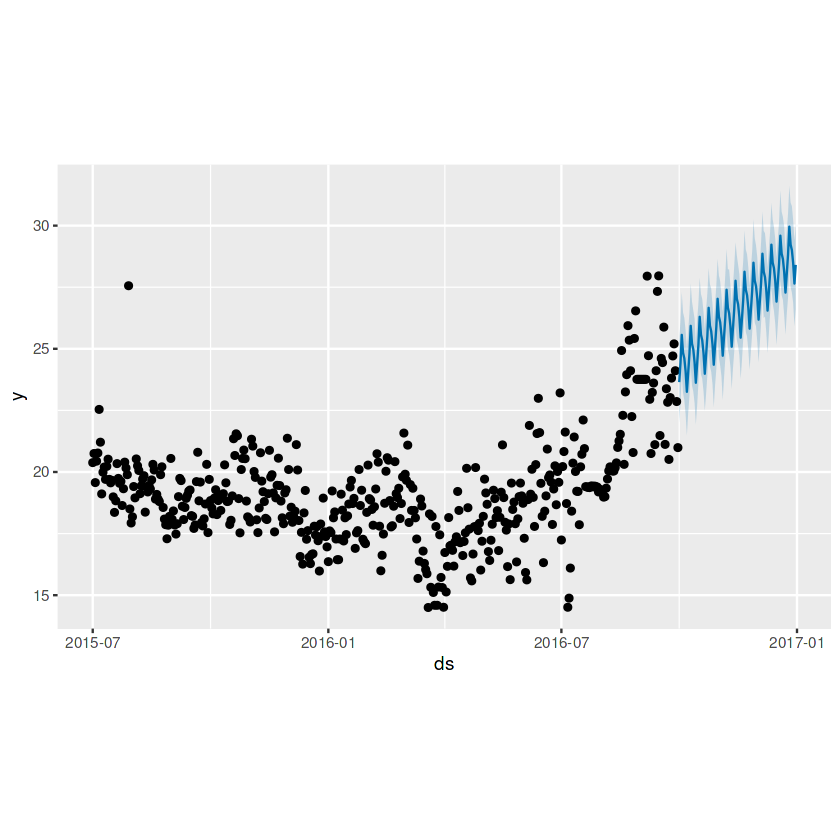

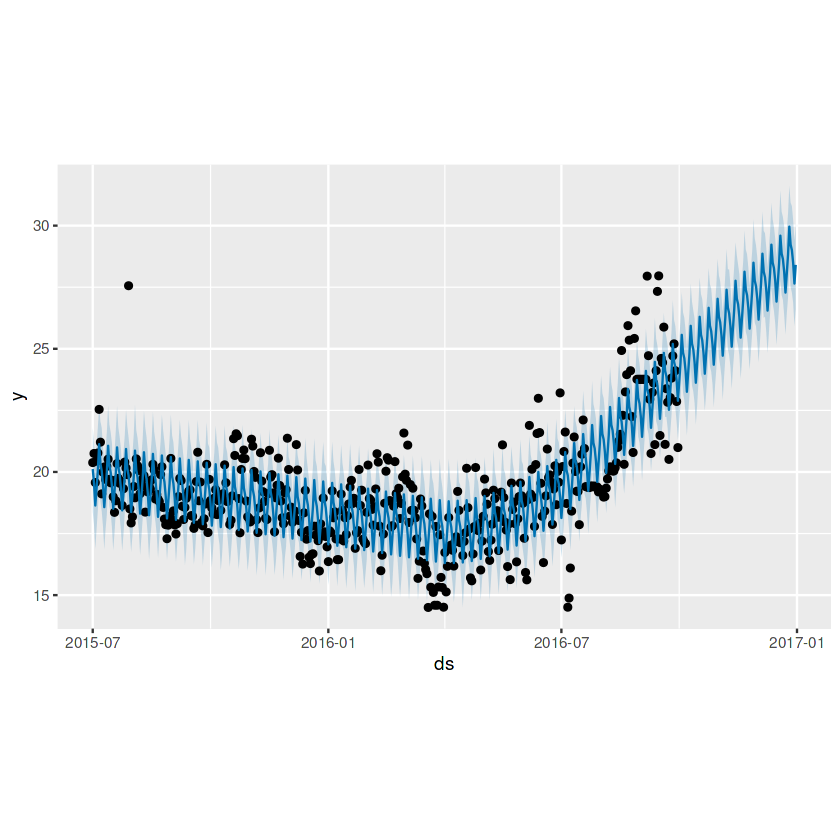

In [61]:
plot(prophet_model, forecast)
plot(prophet_model, prophet_prediction)

# Auto-Arima

## Fit Auto-ARIMA Model

In [62]:
# Load required packages
library(forecast)
library(ggplot2)
library(data.table)


In [63]:
# Fit the Auto-ARIMA model
auto_arima_model <- auto.arima(train$Views, stepwise = FALSE, approximation = FALSE, trace = TRUE)
summary(auto_arima_model)



 ARIMA(0,1,0)                    : 1690.449
 ARIMA(0,1,0) with drift         : 1692.466
 ARIMA(0,1,1)                    : 1620.712
 ARIMA(0,1,1) with drift         : 1622.566
 ARIMA(0,1,2)                    : 1574.325
 ARIMA(0,1,2) with drift         : 1576.055
 ARIMA(0,1,3)                    : 1566.312
 ARIMA(0,1,3) with drift         : 1567.98
 ARIMA(0,1,4)                    : 1562.509
 ARIMA(0,1,4) with drift         : 1564.303
 ARIMA(0,1,5)                    : 1554.983
 ARIMA(0,1,5) with drift         : 1556.896
 ARIMA(1,1,0)                    : 1665.775
 ARIMA(1,1,0) with drift         : 1667.8
 ARIMA(1,1,1)                    : 1572.323
 ARIMA(1,1,1) with drift         : 1573.994
 ARIMA(1,1,2)                    : 1571.977
 ARIMA(1,1,2) with drift         : 1573.669
 ARIMA(1,1,3)                    : 1567.132
 ARIMA(1,1,3) with drift         : 1568.823
 ARIMA(1,1,4)                    : 1553.014
 ARIMA(1,1,4) with drift         : 1554.99
 ARIMA(2,1,0)                    : 

Series: train$Views 
ARIMA(3,1,2) 

Coefficients:
         ar1      ar2      ar3      ma1     ma2
      0.7391  -0.2771  -0.2619  -1.2753  0.4842
s.e.  0.0871   0.0660   0.0559   0.0811  0.0743

sigma^2 = 1.644:  log likelihood = -760.22
AIC=1532.43   AICc=1532.62   BIC=1557.18

Training set error measures:
                     ME    RMSE       MAE        MPE     MAPE      MASE
Training set 0.02255213 1.27376 0.9117404 -0.2616139 4.735534 0.8316122
                    ACF1
Training set -0.01734913

## Forecast

In [64]:
# Forecast for the test period
auto_arima_forecast <- forecast(auto_arima_model, h = nrow(test))
forecast_values <- auto_arima_forecast$mean


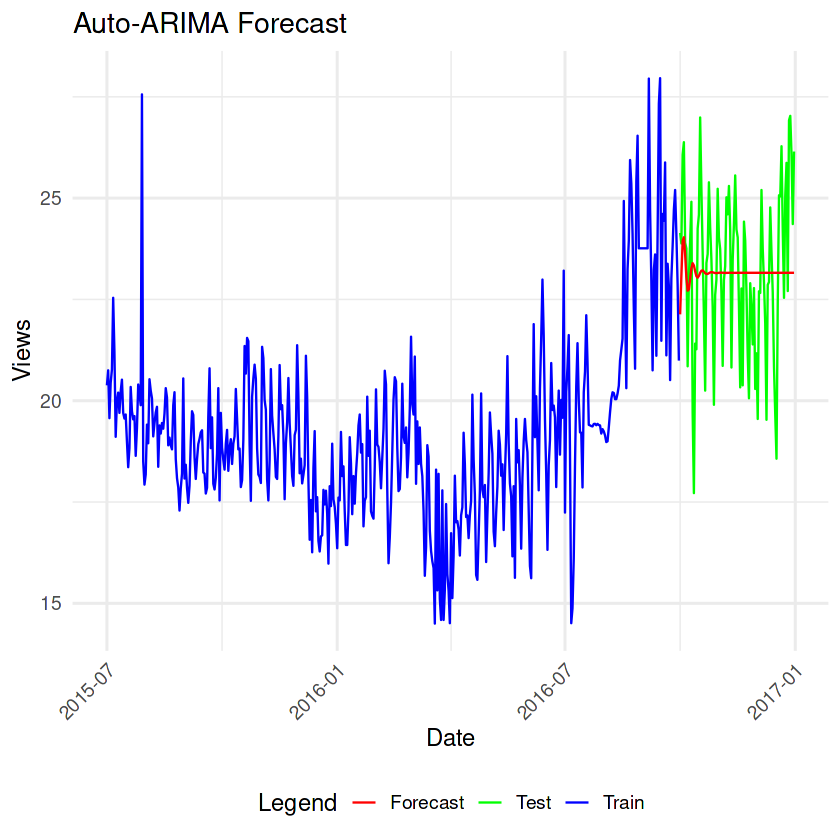

In [65]:
# Create data frames for plotting
train_plot <- data.frame(Date = train$Date, Views = train$Views)
test_plot <- data.frame(Date = test$Date, Views = test$Views)
forecast_plot <- data.frame(Date = test$Date, Forecast = forecast_values)

# Plot the actual vs forecasted values
ggplot() +
  geom_line(data = train_plot, aes(x = Date, y = Views, color = "Train")) +
  geom_line(data = test_plot, aes(x = Date, y = Views, color = "Test")) +
  geom_line(data = forecast_plot, aes(x = Date, y = Forecast, color = "Forecast")) +
  labs(
    title = "Auto-ARIMA Forecast",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Train" = "blue", "Test" = "green", "Forecast" = "red")) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend("Legend"))


## RMSE of Auto-ARIMA model

In [66]:
# Calculate RMSE for the Auto-ARIMA model's forecasts
auto_arima_rmse <- sqrt(mean((forecast_values - test$Views)^2))
print(paste("RMSE: ", auto_arima_rmse))



[1] "RMSE:  1.98815527260257"


# LSTM

## LSTM (epochs 50)

In [67]:
# Assuming `top_page_df` is your data frame
str(top_page_df)
head(top_page_df)

# Define the training and testing sets
train <- top_page_df[Date <= as.Date("2016-09-30")]
test <- top_page_df[Date >= as.Date("2016-10-01")]

dim(train)
dim(test)

Classes ‘data.table’ and 'data.frame':	550 obs. of  2 variables:
 $ Date : Date, format: "2015-07-01" "2015-07-02" ...
 $ Views: num  20.4 20.8 19.6 20.4 20.8 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Date,Views
<date>,<dbl>
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77
2015-07-06,22.54


[1] 458   2

[1] 92  2

Loading required package: keras



Loading required package: tensorflow



Shape of X_train_lstm: 451 7 1 


Shape of y_train_lstm: 451 


Shape of X_test_lstm: 85 7 1 


Shape of y_test_lstm: 85 


[1] "RMSE:  4.54286730233469"


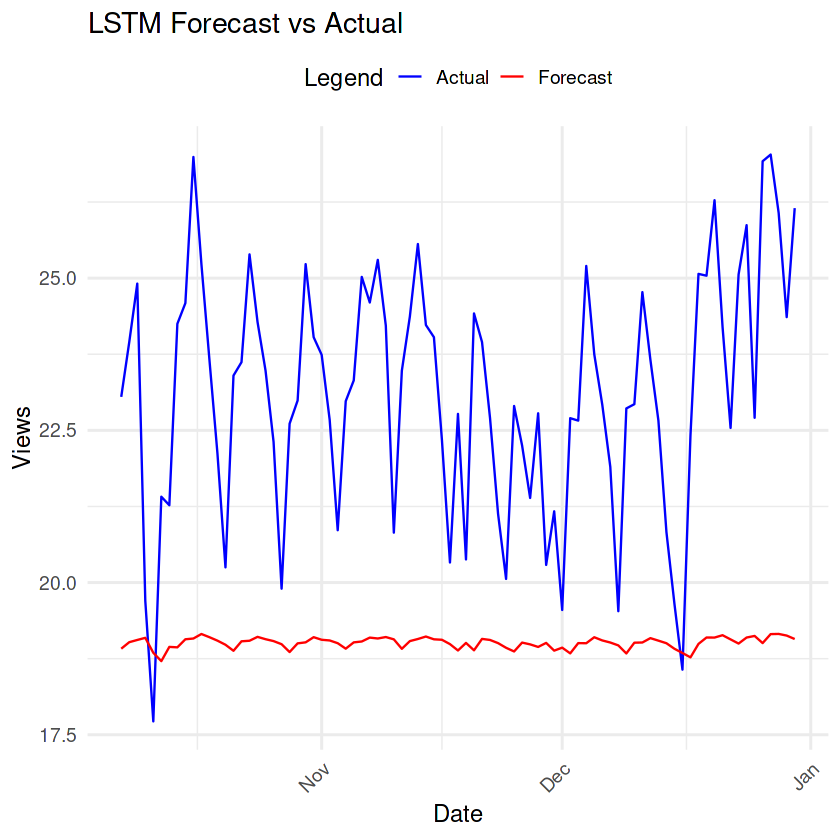

In [68]:
# Install required packages if not already installed
if (!require(keras)) install.packages("keras")
if (!require(tensorflow)) install.packages("tensorflow")

# Load required packages
library(keras)
library(tensorflow)
library(data.table)
library(ggplot2)

# Define the function to transform the dataset
transform_dataset <- function(X, y, time_steps = 7) {
  Xs <- array(0, dim = c((nrow(X) - time_steps), time_steps, 1))
  ys <- numeric(nrow(X) - time_steps)
  for (i in 1:(nrow(X) - time_steps)) {
    Xs[i,,1] <- as.matrix(X[i:(i + time_steps - 1), ])
    ys[i] <- y[i + time_steps]
  }
  list(Xs, ys)
}

# Define the time steps
time_steps <- 7

# Prepare the data
X_train <- as.data.table(train[, .(Views)])
y_train <- train$Views

X_test <- as.data.table(test[, .(Views)])
y_test <- test$Views

# Transform the data for LSTM
train_transformed <- transform_dataset(X_train, y_train, time_steps)
X_train_lstm <- train_transformed[[1]]
y_train_lstm <- train_transformed[[2]]

test_transformed <- transform_dataset(X_test, y_test, time_steps)
X_test_lstm <- test_transformed[[1]]
y_test_lstm <- test_transformed[[2]]

# Print shapes for debugging
cat("Shape of X_train_lstm:", dim(X_train_lstm), "\n")
cat("Shape of y_train_lstm:", length(y_train_lstm), "\n")
cat("Shape of X_test_lstm:", dim(X_test_lstm), "\n")
cat("Shape of y_test_lstm:", length(y_test_lstm), "\n")

# Build the LSTM model
model <- keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(time_steps, 1)) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = 'mean_squared_error',
  optimizer = optimizer_rmsprop()
)

# Train the model
history <- model %>% fit(
  X_train_lstm, y_train_lstm,
  epochs = 50,
  batch_size = 16,
  validation_split = 0.1,
  verbose = 1,
  shuffle = FALSE
)

# Generate forecasts
lstm_forecast <- model %>% predict(X_test_lstm)

# Calculate RMSE
y_pred <- as.vector(lstm_forecast)
lstm_rmse <- sqrt(mean((y_pred - y_test_lstm)^2))
print(paste("RMSE: ", lstm_rmse))

# Create data frames for actual and forecasted values
test_dates <- test$Date[time_steps:(time_steps + length(y_test_lstm) - 1)]
actual_values <- data.frame(Date = test_dates, Views = y_test_lstm)
forecast_values <- data.frame(Date = test_dates, Views = y_pred)

# Plot the actual vs forecasted values
ggplot() +
  geom_line(data = actual_values, aes(x = Date, y = Views, color = "Actual")) +
  geom_line(data = forecast_values, aes(x = Date, y = Views, color = "Forecast")) +
  labs(
    title = "LSTM Forecast vs Actual",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = c("Actual" = "blue", "Forecast" = "red")) +
  theme(legend.position = "top") +
  guides(colour = guide_legend("Legend"))


# Moving Average

## Fit MA model

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_line()`).”


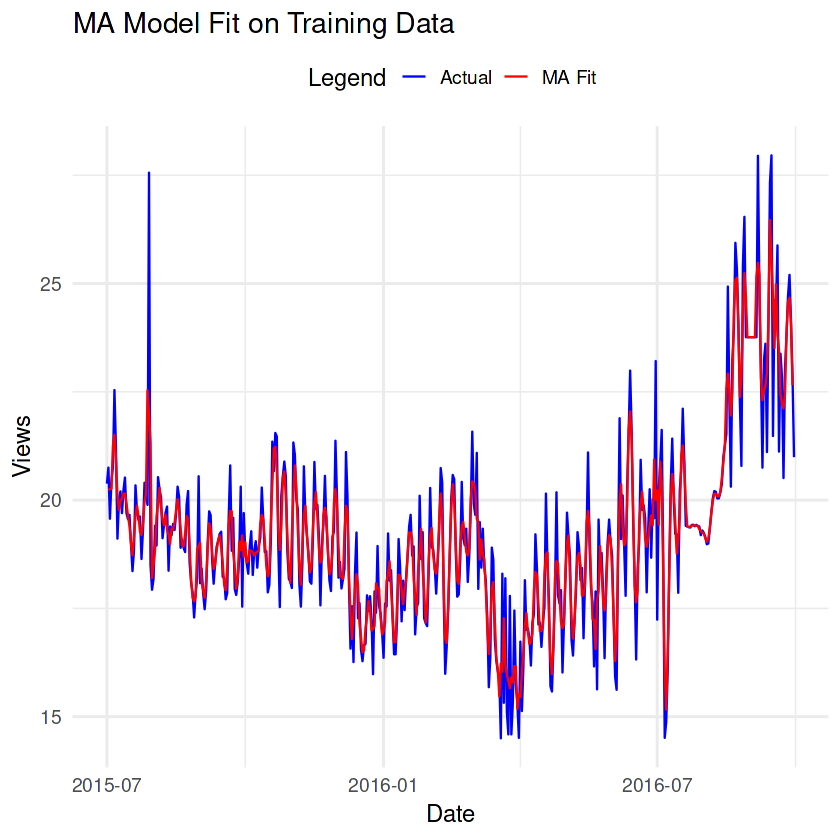

In [69]:
# Fit the MA model with a 3-period moving average
ma_train_fit <- ma(train$Views, order = 3, centre = TRUE)

# Plot the actual vs MA fit values for the training set
ggplot() +
  geom_line(data = train, aes(x = Date, y = Views, color = "Actual")) +
  geom_line(data = data.frame(Date = train$Date, Views = ma_train_fit), aes(x = Date, y = Views, color = "MA Fit")) +
  labs(
    title = "MA Model Fit on Training Data",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  scale_color_manual(values = c("Actual" = "blue", "MA Fit" = "red")) +
  theme(legend.position = "top") +
  guides(colour = guide_legend("Legend"))


## Prediction using MA model

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_line()`).”


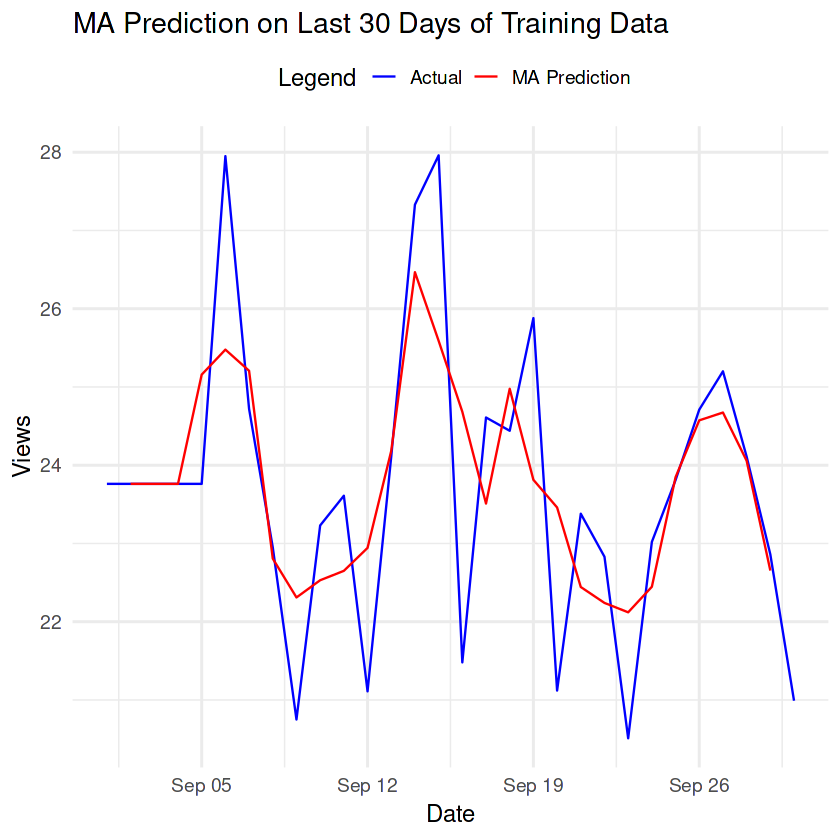

In [70]:
# Predict on the last 30 days of training data
last_30_days_train <- tail(train, 30)
ma_last_30_days <- ma(last_30_days_train$Views, order = 3, centre = TRUE)

# Plot the actual vs MA prediction for the last 30 days of training data
ggplot() +
  geom_line(data = data.frame(Date = last_30_days_train$Date, Views = last_30_days_train$Views), aes(x = Date, y = Views, color = "Actual")) +
  geom_line(data = data.frame(Date = last_30_days_train$Date, Views = ma_last_30_days), aes(x = Date, y = Views, color = "MA Prediction")) +
  labs(
    title = "MA Prediction on Last 30 Days of Training Data",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  scale_color_manual(values = c("Actual" = "blue", "MA Prediction" = "red")) +
  theme(legend.position = "top") +
  guides(colour = guide_legend("Legend"))


## Forecasting on test data using MA model

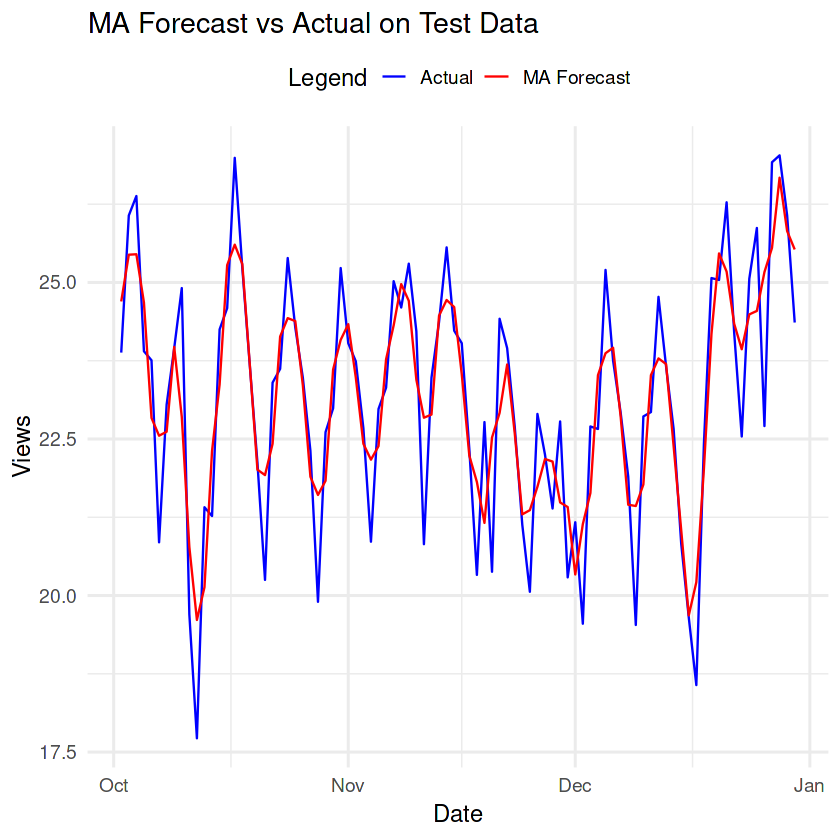

In [71]:
# Forecast for the test data
ma_forecast <- ma(test$Views, order = 3, centre = TRUE)
valid_forecast <- na.omit(ma_forecast)
valid_dates <- test$Date[!is.na(ma_forecast)]
valid_actual <- test$Views[!is.na(ma_forecast)]

# Plot the actual vs MA forecast for the test data
ggplot() +
  geom_line(data = data.frame(Date = valid_dates, Views = valid_actual), aes(x = Date, y = Views, color = "Actual")) +
  geom_line(data = data.frame(Date = valid_dates, Views = valid_forecast), aes(x = Date, y = Views, color = "MA Forecast")) +
  labs(
    title = "MA Forecast vs Actual on Test Data",
    x = "Date",
    y = "Views"
  ) +
  theme_minimal(base_size = 14) +
  scale_color_manual(values = c("Actual" = "blue", "MA Forecast" = "red")) +
  theme(legend.position = "top") +
  guides(colour = guide_legend("Legend"))


## RMSE of MA model

In [72]:
# Calculate RMSE
ma_rmse <- sqrt(mean((valid_forecast - valid_actual)^2))
print(paste("RMSE: ", ma_rmse))


[1] "RMSE:  1.00841220417143"


# Model evaluation

## Comparison Table of RMSE Values

In [73]:
# Create a data frame for RMSE comparison
rmse_comparison <- data.frame(
  Model = c("ARMA", "ARIMA", "Exponential Smoothing", "Prophet", "Auto ARIMA", "LSTM", "Moving Average"),
  RMSE = c(arma_rmse_value, arima_rmse_value, exp_smoothing_rmse, prophet_rmse, auto_arima_rmse, lstm_rmse, ma_rmse)
)

# Print the comparison table
print(rmse_comparison)


                  Model     RMSE
1                  ARMA 1.770417
2                 ARIMA 1.720409
3 Exponential Smoothing 2.189830
4               Prophet 3.985936
5            Auto ARIMA 1.988155
6                  LSTM 4.542867
7        Moving Average 1.008412


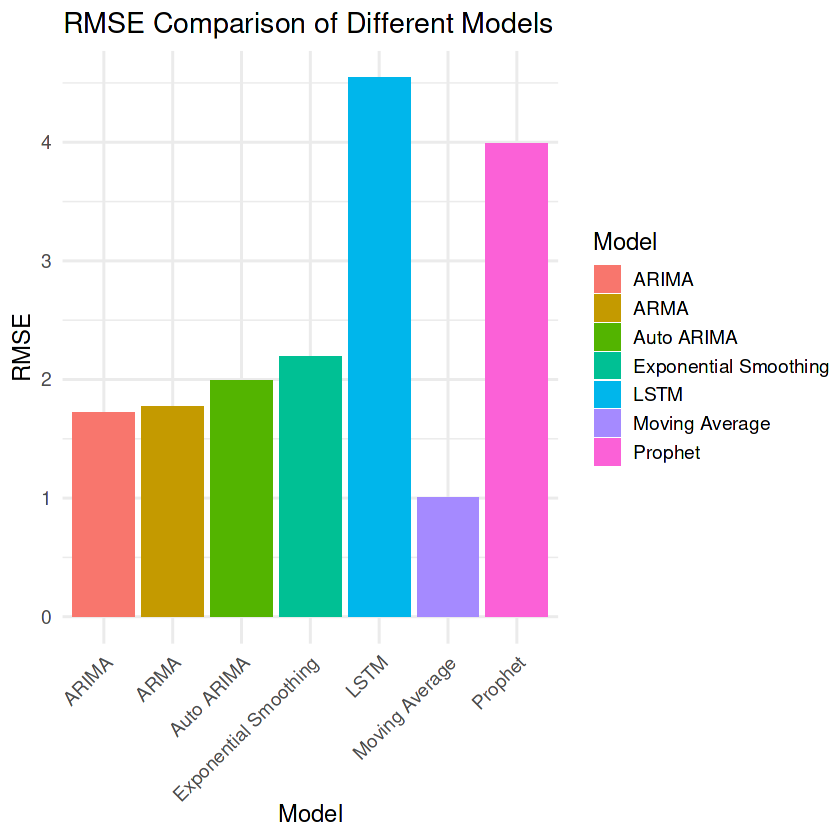

In [74]:
# Load required packages
library(ggplot2)



# Visualize the comparison
ggplot(rmse_comparison, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity") +
  labs(
    title = "RMSE Comparison of Different Models",
    x = "Model",
    y = "RMSE"
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
